## HybridMTLNet

In [ ]:
!pip install --upgrade numpy==1.26.4 scipy==1.11.3 albumentations==1.3.1

In [ ]:
# Cell 0: Setup & configs
import os
import random
import math
import shutil
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import autocast, GradScaler

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Paths (edit these to your workspace)
ESOPH_DIR = "/content/drive/MyDrive/Manvith/Endoscopy-esophagus/Esophagus"
NON_ESOPH_DIR = "/content/drive/MyDrive/Manvith/Endoscopy-esophagus/Non-Esophagus"
MASK_DIR = "/content/drive/MyDrive/Manvith/Endoscopy-esophagus/Masks2"

# Training config
NUM_FOLDS = 5
EPOCHS = 30
BATCH_SIZE = 8
PATIENCE = 7
LR = 1e-4
NUM_WORKERS = 0  # <-- critical: avoid child process error on Colab
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [ ]:
# Cell 1: Collect all images + labels

import glob

# Eso = 1, NonEso = 0
eso_imgs  = sorted(glob.glob(os.path.join(ESOPH_DIR, "*.png")) + glob.glob(os.path.join(ESOPH_DIR, "*.jpg")) + glob.glob(os.path.join(ESOPH_DIR, "*.jpeg")))
non_imgs  = sorted(glob.glob(os.path.join(NON_ESOPH_DIR, "*.png")) + glob.glob(os.path.join(NON_ESOPH_DIR, "*.jpg")) + glob.glob(os.path.join(NON_ESOPH_DIR, "*.jpeg")))

eso_labels  = [1] * len(eso_imgs)
non_labels  = [0] * len(non_imgs)

all_images = eso_imgs + non_imgs
all_labels = eso_labels + non_labels

print("Total images:", len(all_images))
print(" Eso (1):", len(eso_imgs))
print(" NonEso (0):", len(non_imgs))

Total images: 10662
 Eso (1): 8973
 NonEso (0): 1689


In [ ]:
# Cell 2: transforms and offline augmentation to balance Non-Eso (train & val only)
NON_ESO_AUG_DIR = os.path.join(os.path.dirname(NON_ESOPH_DIR), "Non-Esophagus-Aug")
os.makedirs(NON_ESO_AUG_DIR, exist_ok=True)

# Transforms: Eso - standard train/val/test; Non-Eso - separate augmentations for train/val
eso_train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(),
    ToTensorV2()
])

eso_val_test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

non_eso_train_val_augment = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.GaussNoise(p=0.2),
    A.ColorJitter(p=0.3),
    A.Normalize(),
    ToTensorV2()
])

non_eso_test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

def augment_non_eso_to_target(orig_paths, target_count, transform, out_dir, prefix):
    """Offline augment Non-Eso images until there are target_count images (returns list of new file paths)."""
    if target_count <= len(orig_paths):
        return []
    new_paths = []
    idx = 0
    while len(orig_paths) + len(new_paths) < target_count:
        src = orig_paths[idx % len(orig_paths)]
        img = cv2.cvtColor(cv2.imread(src), cv2.COLOR_BGR2RGB)
        aug = transform(image=img)['image']  # Tensor (C,H,W)
        aug_np = aug.permute(1,2,0).cpu().numpy()
        fname = f"{prefix}_aug_{len(new_paths)}.png"
        save_path = os.path.join(out_dir, fname)
        # Convert RGB -> BGR for imwrite
        cv2.imwrite(save_path, cv2.cvtColor((aug_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
        new_paths.append(save_path)
        idx += 1
    return new_paths

In [ ]:
# Cell 3: collect paths and do per-class stratified split
from sklearn.model_selection import train_test_split

eso_images = sorted(glob.glob(os.path.join(ESOPH_DIR, "*.png"))) \
           + sorted(glob.glob(os.path.join(ESOPH_DIR, "*.jpg"))) \
           + sorted(glob.glob(os.path.join(ESOPH_DIR, "*.jpeg")))

non_images = sorted(glob.glob(os.path.join(NON_ESOPH_DIR, "*.png"))) \
           + sorted(glob.glob(os.path.join(NON_ESOPH_DIR, "*.jpg"))) \
           + sorted(glob.glob(os.path.join(NON_ESOPH_DIR, "*.jpeg")))

print(f"Found Eso: {len(eso_images)}, Non-Eso: {len(non_images)}")

# simple stratified splits per class
def stratified_split_per_class(imgs, label, test_size=0.15, val_size=0.15):
    train, temp = train_test_split(imgs, test_size=(val_size+test_size), random_state=SEED)
    val, test = train_test_split(temp, test_size=test_size/(val_size+test_size), random_state=SEED)
    return train, [label]*len(train), val, [label]*len(val), test, [label]*len(test)

eso_train, eso_train_lbl, eso_val, eso_val_lbl, eso_test, eso_test_lbl = stratified_split_per_class(eso_images, 1)
non_train, non_train_lbl, non_val, non_val_lbl, non_test, non_test_lbl = stratified_split_per_class(non_images, 0)

print("Before balancing:")
print(" Train counts: Eso", len(eso_train), "Non-Eso", len(non_train))
print(" Val counts:   Eso", len(eso_val), "Non-Eso", len(non_val))
print(" Test counts:  Eso", len(eso_test), "Non-Eso", len(non_test))

# Offline augmentation only for Non-Eso train & val to match Eso counts (so we can show counts)
aug_train_new = augment_non_eso_to_target(non_train, len(eso_train), non_eso_train_val_augment, NON_ESO_AUG_DIR, "train")
aug_val_new   = augment_non_eso_to_target(non_val, len(eso_val), non_eso_train_val_augment, NON_ESO_AUG_DIR, "val")

non_train_bal = non_train + aug_train_new
non_val_bal   = non_val + aug_val_new
non_test_bal  = non_test  # no augmentation for test

print("\nAfter balancing (offline augmentation):")
print(" Train counts: Eso", len(eso_train), "Non-Eso", len(non_train_bal))
print(" Val counts:   Eso", len(eso_val), "Non-Eso", len(non_val_bal))
print(" Test counts:  Eso", len(eso_test), "Non-Eso", len(non_test_bal))

Found Eso: 8973, Non-Eso: 1689
Before balancing:
 Train counts: Eso 6281 Non-Eso 1182
 Val counts:   Eso 1346 Non-Eso 253
 Test counts:  Eso 1346 Non-Eso 254

After balancing (offline augmentation):
 Train counts: Eso 6281 Non-Eso 6281
 Val counts:   Eso 1346 Non-Eso 1346
 Test counts:  Eso 1346 Non-Eso 254


In [ ]:
# Cell 4: Dataset and collate function (always returns valid masks)
import os, numpy as np, torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class EsophagusDataset(Dataset):
    def __init__(self, image_paths, labels, mask_dir=None, transform=None):
        """
        - image_paths: list of full file paths
        - labels: list of ints 0/1
        - mask_dir: folder with masks named like <base>_mask.png or same basename
        - transform: albumentations transform
        """
        self.image_paths = list(image_paths)
        self.labels = list(labels)
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def _find_mask_for_image(self, img_path):
        base = os.path.splitext(os.path.basename(img_path))[0]
        candidates = [f"{base}.png", f"{base}.jpg", f"{base}_mask.png", f"{base}_mask.jpg"]
        for c in candidates:
            p = os.path.join(self.mask_dir, c) if self.mask_dir else None
            if p and os.path.exists(p):
                return p
        return None

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = int(self.labels[idx])

        img = np.array(Image.open(img_path).convert("RGB"))

        # Always return a mask (zeros if not available)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        if label == 1 and self.mask_dir is not None:
            mask_path = self._find_mask_for_image(img_path)
            if mask_path is not None:
                mask = np.array(Image.open(mask_path).convert("L"), dtype=np.uint8)
                mask = (mask > 127).astype(np.uint8)

        # Albumentations
        if self.transform:
            out = self.transform(image=img, mask=mask)
            img_t, mask_t = out['image'], out['mask']
        else:
            img_t = transforms.ToTensor()(img)
            mask_t = torch.from_numpy(mask).long()

        if isinstance(mask_t, np.ndarray):
            mask_t = torch.from_numpy(mask_t).long()
        elif isinstance(mask_t, torch.Tensor) and mask_t.dtype != torch.long:
            mask_t = mask_t.long()

        return img_t, mask_t, label


def collate_fn(batch):
    imgs, masks, labels = zip(*batch)
    imgs = torch.stack(imgs, dim=0)             # (B,C,H,W)
    labels = torch.tensor(labels, dtype=torch.long)

    B, C, H, W = imgs.shape
    out_masks = []
    seg_present = []

    for m in masks:
        seg_present.append(m.sum() > 0)
        m = m.float()
        if m.shape != (H, W):
            m = F.interpolate(m.unsqueeze(0).unsqueeze(0),
                              size=(H, W), mode="nearest").squeeze(0).squeeze(0)
        out_masks.append(m)

    masks_tensor = torch.stack(out_masks, dim=0)  # (B,H,W) float32
    seg_present = torch.tensor(seg_present, dtype=torch.bool)

    return imgs, masks_tensor, labels, seg_present

In [ ]:
# Cell 5: Build datasets & loaders (use transforms defined earlier)
def make_dataset(imgs, labels, split):
    if split == "train":
        transform = eso_train_transform
    elif split == "val":
        transform = eso_val_test_transform
    else:
        transform = eso_val_test_transform

    return EsophagusDataset(imgs, labels, mask_dir=MASK_DIR, transform=transform)

train_imgs = eso_train + non_train_bal
train_labels = [1]*len(eso_train) + [0]*len(non_train_bal)
val_imgs = eso_val + non_val_bal
val_labels = [1]*len(eso_val) + [0]*len(non_val_bal)
test_imgs = eso_test + non_test_bal
test_labels = [1]*len(eso_test) + [0]*len(non_test_bal)

train_dataset = make_dataset(train_imgs, train_labels, "train")
val_dataset = make_dataset(val_imgs, val_labels, "val")
test_dataset = make_dataset(test_imgs, test_labels, "test")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, collate_fn=collate_fn, pin_memory=True)

print("Dataset sizes -> Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))

Dataset sizes -> Train: 12562 Val: 2692 Test: 1600


In [ ]:
# Cell 6: utilities — derive 4-class mask, one-hot, metrics
def derive_4class_from_binary_np(eso_np, boundary_width=3, uncertainty_width=6):
    """
    eso_np: 2D numpy binary mask (0/1)
    returns: 2D numpy label map with values {0:bg,1:eso,2:boundary,3:uncertain}
    """
    if eso_np.ndim != 2:
        eso_np = np.squeeze(eso_np)
    eso = (eso_np > 0).astype(np.uint8)
    if eso.sum() == 0:
        # empty mask -> all background
        return np.zeros_like(eso, dtype=np.uint8)

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (boundary_width*2+1, boundary_width*2+1))
    dil = cv2.dilate(eso, k)
    ero = cv2.erode(eso, k)
    boundary = ((dil - ero) > 0).astype(np.uint8)

    k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (uncertainty_width*2+1, uncertainty_width*2+1))
    dil2 = cv2.dilate(eso, k2)
    ero2 = cv2.erode(eso, k2)
    uncertain = ((dil2 - ero2) > 0).astype(np.uint8)

    out = np.zeros_like(eso, dtype=np.uint8)
    out[eso == 0] = 0
    out[eso == 1] = 1
    out[boundary == 1] = 2
    out[uncertain == 1] = 3
    return out

def to_one_hot_idx_mask(idx_mask_tensor, num_classes=4):
    # idx_mask_tensor: (B,H,W) LongTensor
    return F.one_hot(idx_mask_tensor.long(), num_classes=num_classes).permute(0,3,1,2).float()

def dice_coef_from_logits(logits, target_idx_mask, class_index=1, eps=1e-8):
    # logits: (B,C,H,W), target_idx_mask: (B,H,W) int
    probs = F.softmax(logits, dim=1)[:, class_index]  # (B,H,W)
    y = (target_idx_mask == class_index).float()
    inter = (probs * y).sum(dim=(1,2))
    denom = probs.sum(dim=(1,2)) + y.sum(dim=(1,2)) + eps
    dice = (2*inter + eps) / denom
    return dice.mean().item()

def iou_from_binary_preds(pred_bin, target_bin, eps=1e-8):
    # pred_bin, target_bin shape (H,W) tensors 0/1
    pred = (pred_bin > 0.5).float()
    target = target_bin.float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return (inter + eps) / (union + eps)

In [ ]:
# Cell 7: HybridMTLNet (CNN + Transformer encoder, U-decoder, heads)
# ---------- building blocks (same as your provided code) ----------
def conv3x3(in_ch, out_ch, s=1, g=1, bias=False):
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=s, padding=1, groups=g, bias=bias)
def conv1x1(in_ch, out_ch, s=1, bias=False):
    return nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=s, padding=0, bias=bias)

class SE(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(c, c//r, 1), nn.ReLU(True),
            nn.Conv2d(c//r, c, 1), nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(self.pool(x))
        return x * w

class ResidualBlock(nn.Module):
    def __init__(self, c, expansion=4, dw_groups=None):
        super().__init__()
        dwg = dw_groups if dw_groups is not None else c
        self.dw = conv3x3(c, c, g=dwg)
        self.bn1 = nn.BatchNorm2d(c)
        self.pw1 = conv1x1(c, c*expansion)
        self.act = nn.GELU()
        self.pw2 = conv1x1(c*expansion, c)
        self.bn2 = nn.BatchNorm2d(c)
        self.se = SE(c)
    def forward(self, x):
        idn = x
        x = self.dw(x)
        x = self.bn1(x)
        x = self.pw1(x); x = self.act(x); x = self.pw2(x)
        x = self.bn2(x)
        x = self.se(x)
        return self.act(x + idn)

class PatchEmbed(nn.Module):
    def __init__(self, in_ch, embed_dim, patch_size=4):
        super().__init__()
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size, padding=0)
        self.norm = nn.BatchNorm2d(embed_dim)
    def forward(self, x):
        x = self.proj(x)
        return self.norm(x)

class MHSA(nn.Module):
    def __init__(self, dim, num_heads=4, window=7, dropout=0.0):
        super().__init__()
        assert dim % num_heads == 0
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim*3, bias=True)
        self.proj = nn.Linear(dim, dim)
        self.drop = nn.Dropout(dropout)
        self.window = window

    def partition(self, x):
        B,C,H,W = x.shape
        w = self.window
        pad_h = (w - H % w) % w
        pad_w = (w - W % w) % w
        x = F.pad(x, (0,pad_w, 0,pad_h))
        _,_,Hp,Wp = x.shape
        x = x.reshape(B, C, Hp//w, w, Wp//w, w)
        x = x.permute(0,2,4,1,3,5).reshape(-1, C, w, w)
        return x, Hp, Wp, pad_h, pad_w

    def reverse(self, xw, B, C, Hp, Wp):
        w = self.window
        xw = xw.reshape(B, Hp//w, Wp//w, C, w, w).permute(0,3,1,4,2,5).reshape(B, C, Hp, Wp)
        return xw

    def forward(self, x):
        B,C,H,W = x.shape
        xw, Hp, Wp, pad_h, pad_w = self.partition(x)
        Bw, Cw, w, _ = xw.shape
        xw_flat = xw.flatten(2).transpose(1,2)
        qkv = self.qkv(xw_flat).reshape(Bw, w*w, 3, self.num_heads, self.head_dim)
        q,k,v = qkv.unbind(dim=2)
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)
        attn = (q @ k.transpose(-2,-1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.drop(attn)
        out = attn @ v
        out = out.transpose(1,2).reshape(Bw, w*w, self.dim)
        out = self.proj(out)
        out = self.drop(out)
        out = out.transpose(1,2).reshape(Bw, self.dim, w, w)
        xr = self.reverse(out, B, self.dim, Hp, Wp)
        xr = xr[:, :, :H, :W]
        return xr

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=4, window=7, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        self.n1 = nn.GroupNorm(1, dim)
        self.attn = MHSA(dim, num_heads, window, drop)
        self.n2 = nn.GroupNorm(1, dim)
        hidden = int(dim*mlp_ratio)
        self.mlp = nn.Sequential(nn.Conv2d(dim, hidden, 1), nn.GELU(), nn.Conv2d(hidden, dim, 1))
    def forward(self, x):
        x = x + self.attn(self.n1(x))
        x = x + self.mlp(self.n2(x))
        return x

class CrossScaleFusion(nn.Module):
    def __init__(self, c_low, c_high, c_out):
        super().__init__()
        self.proj_low  = conv1x1(c_low,  c_out)
        self.proj_high = conv1x1(c_high, c_out)
        self.gate = nn.Sequential(nn.Conv2d(c_out*2, c_out, 1), nn.GELU(), nn.Conv2d(c_out, c_out, 1), nn.Sigmoid())
        self.out = ResidualBlock(c_out)
    def forward(self, low, high):
        if high.shape[-2:] != low.shape[-2:]:
            high = F.interpolate(high, size=low.shape[-2:], mode='bilinear', align_corners=False)
        L = self.proj_low(low)
        H = self.proj_high(high)
        g = self.gate(torch.cat([L,H], dim=1))
        fused = L * g + H * (1-g)
        return self.out(fused)

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv = nn.Sequential(conv3x3(in_ch + skip_ch, out_ch), nn.BatchNorm2d(out_ch), nn.GELU(), ResidualBlock(out_ch))
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

# Encoder/Decoder/Heads (kept as in your original)
class HybridEncoder(nn.Module):
    def __init__(self, in_ch=3, dims=(64,128,256,512), heads=(2,4), windows=(7,7)):
        super().__init__()
        c1,c2,c3,c4 = dims
        self.stem = nn.Sequential(nn.Conv2d(in_ch, c1, 7, stride=2, padding=3, bias=False), nn.BatchNorm2d(c1), nn.GELU(), ResidualBlock(c1), ResidualBlock(c1))
        self.down2 = nn.Sequential(nn.Conv2d(c1, c2, 3, stride=2, padding=1, bias=False), nn.BatchNorm2d(c2), nn.GELU(), ResidualBlock(c2), SE(c2))
        self.patch3 = PatchEmbed(c2, c3//2, patch_size=2)
        self.conv_adj3 = conv1x1(c3//2, c3)
        self.tf3 = nn.Sequential(TransformerBlock(c3, num_heads=heads[0], window=windows[0]), TransformerBlock(c3, num_heads=heads[0], window=windows[0]))
        self.patch4 = PatchEmbed(c3, c4//2, patch_size=2)
        self.conv_adj4 = conv1x1(c4//2, c4)
        self.tf4 = nn.Sequential(TransformerBlock(c4, num_heads=heads[1], window=windows[1]), TransformerBlock(c4, num_heads=heads[1], window=windows[1]))

    def forward(self, x):
        s1 = self.stem(x)
        s2 = self.down2(s1)
        s3 = self.conv_adj3(self.patch3(s2)); s3 = self.tf3(s3)
        s4 = self.conv_adj4(self.patch4(s3)); s4 = self.tf4(s4)
        return s1, s2, s3, s4

class DecoderMTL(nn.Module):
    def __init__(self, dims=(64,128,256,512), dec_dims=(256,128,64)):
        super().__init__()
        c1,c2,c3,c4 = dims
        d3,d2,d1 = dec_dims
        self.fuse43 = CrossScaleFusion(c3, c4, c3)
        self.fuse32 = CrossScaleFusion(c2, c3, c2)
        self.fuse21 = CrossScaleFusion(c1, c2, c1)
        self.up3 = UpBlock(c4, c3, d3)
        self.up2 = UpBlock(d3, c2, d2)
        self.up1 = UpBlock(d2, c1, d1)
        self.boundary_conv = nn.Sequential(conv3x3(d1, d1), nn.BatchNorm2d(d1), nn.GELU())
        # ✅ Binary segmentation head (1 channel)
        self.out_seg = nn.Conv2d(d1, 1, 1)

    def forward(self, s1, s2, s3, s4):
        s3e = self.fuse43(s3, s4)
        s2e = self.fuse32(s2, s3e)
        s1e = self.fuse21(s1, s2e)
        x = self.up3(s4, s3e)
        x = self.up2(x, s2e)
        x = self.up1(x, s1e)
        boundary_feat = self.boundary_conv(x)
        seg_logits = self.out_seg(x)
        return seg_logits, boundary_feat, x

class SegAwareClassifier(nn.Module):
    def __init__(self, in_ch, num_classes=2):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Sequential(
            conv1x1(in_ch, in_ch), nn.GELU(),
            nn.Dropout(0.2),
            conv1x1(in_ch, in_ch//2), nn.GELU()
        )
        self.fc = nn.Linear(in_ch//2, num_classes)

    def forward(self, feat, seg_logits):
        with torch.no_grad():
            seg_prob = torch.sigmoid(seg_logits)  # (B,1,H,W)

        gated = feat * (1.0 + seg_prob)
        x = self.conv(gated)
        x = self.pool(x).flatten(1)
        return self.fc(x)


class Regressor(nn.Module):
    def __init__(self, in_ch_dec, in_ch_bound, out_dims=1):
        super().__init__()
        self.pool_avg = nn.AdaptiveAvgPool2d(1)
        self.pool_max = nn.AdaptiveMaxPool2d(1)
        self.mlp = nn.Sequential(nn.Linear(in_ch_dec*2 + in_ch_bound*2, in_ch_dec), nn.GELU(), nn.Dropout(0.2), nn.Linear(in_ch_dec, out_dims))
    def forward(self, dec_feat, boundary_feat):
        a1 = self.pool_avg(dec_feat).flatten(1); m1 = self.pool_max(dec_feat).flatten(1)
        a2 = self.pool_avg(boundary_feat).flatten(1); m2 = self.pool_max(boundary_feat).flatten(1)
        x = torch.cat([a1,m1,a2,m2], dim=1)
        return self.mlp(x)

class HybridMTLNet(nn.Module):
    def __init__(self, in_ch=3, dims=(64,128,256,512), dec_dims=(256,128,64), heads=(2,4), num_cls=2, reg_out=1):
        super().__init__()
        self.encoder = HybridEncoder(in_ch=in_ch, dims=dims, heads=heads)
        self.decoder = DecoderMTL(dims=dims, dec_dims=dec_dims)
        d1 = dec_dims[-1]
        self.cls_head = SegAwareClassifier(in_ch=d1, num_classes=num_cls)
        self.reg_head = Regressor(in_ch_dec=d1, in_ch_bound=d1, out_dims=reg_out)
    def forward(self, x):
        s1,s2,s3,s4 = self.encoder(x)
        seg_logits, boundary_feat, dec_feat = self.decoder(s1,s2,s3,s4)
        cls_logits = self.cls_head(dec_feat, seg_logits)
        reg_out = self.reg_head(dec_feat, boundary_feat)
        seg_logits_up = F.interpolate(seg_logits, size=x.shape[-2:], mode='bilinear', align_corners=False)
        return {"seg_logits": seg_logits_up, "cls_logits": cls_logits, "regression": reg_out}

# instantiate model to verify
model = HybridMTLNet().to(DEVICE)
with torch.no_grad():
    dummy = torch.randn(2,3,256,256).to(DEVICE)
    out = model(dummy)
    print({k: v.shape for k,v in out.items()})

{'seg_logits': torch.Size([2, 1, 256, 256]), 'cls_logits': torch.Size([2, 2]), 'regression': torch.Size([2, 1])}


In [ ]:
# Model Summary
!pip install torchinfo --quiet

from torchinfo import summary

# Print model summary (layer-wise)
summary(
    model,
    input_size=(2, 3, 256, 256),  # (batch_size, channels, height, width)
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    depth=4  # how deep to expand layers
)

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
HybridMTLNet                                            [2, 3, 256, 256]          [2, 1]                    --                        --                        --
├─HybridEncoder: 1-1                                    [2, 3, 256, 256]          [2, 64, 128, 128]         --                        --                        --
│    └─Sequential: 2-1                                  [2, 3, 256, 256]          [2, 64, 128, 128]         --                        --                        --
│    │    └─Conv2d: 3-1                                 [2, 3, 256, 256]          [2, 64, 128, 128]         9,408                     [7, 7]                    308,281,344
│    │    └─BatchNorm2d: 3-2                            [2, 64, 128, 128]         [2, 64, 128, 128]         128                       --                        256
│    

In [ ]:
# Cell 8: Losses & MultiTaskLoss that handles seg presence mask

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2

# ---------- Helper functions ----------
def derive_4class_from_binary_np(binary_mask):
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(binary_mask, kernel, iterations=1)
    dilated = cv2.dilate(binary_mask, kernel, iterations=1)

    inner = eroded
    boundary = binary_mask - eroded
    outer = np.clip(dilated - binary_mask, 0, 1)

    idx_mask = np.zeros_like(binary_mask, dtype=np.uint8)
    idx_mask[inner == 1] = 1
    idx_mask[boundary == 1] = 2
    idx_mask[outer == 1] = 3
    return idx_mask

def to_one_hot_idx_mask(mask_idx, num_classes):
    """
    mask_idx: (B,H,W) long
    Returns: (B,num_classes,H,W) one-hot float
    """
    b, h, w = mask_idx.shape
    onehot = torch.zeros((b, num_classes, h, w), dtype=torch.float32, device=mask_idx.device)
    return onehot.scatter_(1, mask_idx.unsqueeze(1), 1.0)

# ---------- Loss functions ----------
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        super().__init__()
        self.alpha, self.beta, self.gamma, self.smooth = alpha, beta, gamma, smooth
    def forward(self, logits, targets_onehot):
        probs = F.softmax(logits, dim=1)
        dims = (0,2,3)
        tp = (probs * targets_onehot).sum(dims)
        fp = (probs * (1 - targets_onehot)).sum(dims)
        fn = ((1 - probs) * targets_onehot).sum(dims)
        tversky = (tp + self.smooth) / (tp + self.alpha*fp + self.beta*fn + self.smooth)
        loss = torch.pow(1.0 - tversky, self.gamma)
        return loss.mean()

class LovaszSoftmaxLoss(nn.Module):
    def __init__(self, classes='present'):
        super().__init__()
        self.classes = classes
    def forward(self, logits, labels_idx):
        probs = F.softmax(logits, dim=1)
        B, C, H, W = probs.shape
        probs_flat = probs.permute(0,2,3,1).reshape(-1, C)
        labels_flat = labels_idx.reshape(-1)
        return lovasz_softmax_flat(probs_flat, labels_flat, classes=self.classes)

def lovasz_softmax_flat(probs, labels, classes='present'):
    def lovasz_grad(gt_sorted):
        gts = gt_sorted.sum()
        if gts == 0:
            return gt_sorted * 0.
        p = len(gt_sorted)
        intersection = gts - gt_sorted.cumsum(0)
        union = gts + (1 - gt_sorted).cumsum(0)
        jaccard = 1. - intersection / union
        if p > 1:
            jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
        return jaccard
    C = probs.size(1)
    losses = []
    class_to_sum = list(range(C)) if classes in ['all','present'] else classes
    for c in class_to_sum:
        fg = (labels == c).float()
        if classes == 'present' and fg.sum() == 0:
            continue
        pc = probs[:, c]
        errors = (fg - pc).abs()
        errors_sorted, perm = torch.sort(errors, descending=True)
        fg_sorted = fg[perm]
        grad = lovasz_grad(fg_sorted)
        losses.append(torch.dot(errors_sorted, grad))
    if len(losses) == 0:
        return probs.new_tensor(0.)
    return torch.mean(torch.stack(losses))

class BoundaryLoss(nn.Module):
    def __init__(self, target_classes=(1,2)):
        super().__init__()
        self.target_classes = target_classes
    def forward(self, logits, labels_idx):
        probs = F.softmax(logits, dim=1)
        B, C, H, W = probs.shape
        loss_total = 0.0
        for c in self.target_classes:
            pc = probs[:, c]
            yc = (labels_idx == c).float()
            dist = []
            for b in range(B):
                yb = yc[b].detach().cpu().numpy().astype(np.uint8)
                dt = cv2.distanceTransform(1 - yb, cv2.DIST_L2, 3)
                dt = torch.from_numpy(dt).to(pc.device).float()
                dist.append(dt)
            dist = torch.stack(dist, dim=0)
            loss_total += (pc * dist).mean()
        return loss_total / len(self.target_classes)

import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- Binary Dice Loss ----------
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, logits, targets):
        preds = torch.sigmoid(logits)
        preds = preds.view(-1)
        targets = targets.view(-1).float()
        inter = (preds * targets).sum()
        dice = (2.*inter + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

# ---------- Multi-task Loss ----------
class MultiTaskLossFlexible(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.cls_loss = nn.CrossEntropyLoss()

    def forward(self, outputs, seg_mask, cls_label, seg_present):
        """
        outputs: dict {"seg_logits": (B,1,H,W), "cls_logits": (B,num_classes)}
        seg_mask: (B,H,W) float or long
        cls_label: (B,) long
        seg_present: (B,) bool
        """
        seg_logits = outputs["seg_logits"]
        cls_logits = outputs["cls_logits"]

        # classification loss always applies
        L_cls = self.cls_loss(cls_logits, cls_label)

        # if no samples with segmentation present -> return classification only
        if seg_present.sum() == 0:
            return L_cls, {"L_cls": L_cls.detach()}

        # subset for seg-present samples
        idxs = torch.nonzero(seg_present).squeeze(1)
        seg_logits_sub = seg_logits[idxs]       # (Ns,1,H,W)
        seg_mask_sub   = seg_mask[idxs].unsqueeze(1).float()  # (Ns,1,H,W)

        # BCE + Dice
        L_bce = self.bce(seg_logits_sub, seg_mask_sub)
        L_dice = self.dice(seg_logits_sub, seg_mask_sub)
        L_seg = L_bce + L_dice

        # total
        loss = L_cls + L_seg
        return loss, {
            "L_cls": L_cls.detach(),
            "L_bce": L_bce.detach(),
            "L_dice": L_dice.detach()
        }

# Instantiate criterion
criterion = MultiTaskLossFlexible().to(DEVICE)

In [ ]:
# Cell 9: Criterion Helper
def prepare_batch_for_criterion(masks, img_shape, device):
    """Prepare ground truth masks (binary) and seg_present flags."""
    B, _, H, W = img_shape
    seg_mask_tensor = torch.zeros((B, H, W), dtype=torch.long, device=device)
    seg_present = torch.zeros((B,), dtype=torch.bool, device=device)

    for i, m in enumerate(masks):
        if m is not None:
            seg_present[i] = True
            seg_mask_tensor[i] = F.interpolate(
                m.unsqueeze(0).unsqueeze(0).float(),
                size=(H, W),
                mode="nearest"
            ).squeeze(0).squeeze(0).long()
    return seg_mask_tensor, seg_present

In [ ]:
# Cell 10: Training and Validation (with tqdm, AMP, and Dice)
from tqdm import tqdm
import torch
from torch.amp import autocast, GradScaler

def dice_score(preds, targets, eps=1e-6):
    preds = torch.sigmoid(preds) > 0.5
    preds = preds.view(-1).float()
    targets = targets.view(-1).float()
    inter = (preds * targets).sum()
    return (2.*inter + eps) / (preds.sum() + targets.sum() + eps)

def train_one_epoch(model, loader, optimizer, criterion, device, epoch, num_epochs, scaler):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch}/{num_epochs} [Train]", leave=False)
    for imgs, masks, labels, seg_present in pbar:   # ✅ collate_fn must return 4 values
        imgs = imgs.to(device)
        masks = masks.to(device).float()
        labels = labels.to(device).long()
        seg_present = seg_present.to(device)

        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type=device.type):
            outputs = model(imgs)
            loss, comps = criterion(outputs, masks, labels, seg_present)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accuracy
        preds_cls = outputs["cls_logits"].argmax(dim=1)
        acc = (preds_cls == labels).float().mean().item()

        bs = imgs.size(0)
        running_loss += loss.item() * bs
        running_acc += acc * bs
        total += bs

        pbar.set_postfix(loss=loss.item(), acc=acc)

    return running_loss/total, running_acc/total


def validate_one_epoch(model, loader, criterion, device, epoch, num_epochs):
    model.eval()
    running_loss, running_acc, running_dice = 0.0, 0.0, 0.0
    total = 0
    y_true, y_pred = [], []

    pbar = tqdm(loader, desc=f"Epoch {epoch}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for imgs, masks, labels, seg_present in pbar:
            imgs = imgs.to(device)
            masks = masks.to(device).float()
            labels = labels.to(device).long()
            seg_present = seg_present.to(device)

            outputs = model(imgs)
            loss, comps = criterion(outputs, masks, labels, seg_present)

            preds_cls = outputs["cls_logits"].argmax(dim=1)
            acc = (preds_cls == labels).float().mean().item()

            # Dice only for samples that have segmentation
            if seg_present.sum() > 0:
                idxs = torch.nonzero(seg_present).squeeze(1)
                dice = dice_score(outputs["seg_logits"][idxs], masks[idxs].unsqueeze(1))
            else:
                dice = torch.tensor(0.0, device=device)

            bs = imgs.size(0)
            running_loss += loss.item() * bs
            running_acc += acc * bs
            running_dice += dice.item() * bs
            total += bs

            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds_cls.cpu().numpy().tolist())

            pbar.set_postfix(val_loss=loss.item(), val_acc=acc, val_dice=dice.item())

    return running_loss/total, running_acc/total, y_true, y_pred, running_dice/total

In [ ]:
# Cell 11a: Evaluation per fold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import seaborn as sns

def evaluate_fold(model, val_loader, device=DEVICE):
    model.eval()
    all_labels, all_preds = [], []
    dice_scores = []

    with torch.no_grad():
        for imgs, masks, labels, seg_present in tqdm(val_loader, desc="Evaluating", leave=False):
            imgs, labels, masks, seg_present = imgs.to(device), labels.to(device), masks.to(device), seg_present.to(device)

            outputs = model(imgs)
            cls_logits = outputs["cls_logits"]
            seg_logits = outputs["seg_logits"]

            preds = cls_logits.argmax(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Dice score
            for i in range(len(imgs)):
                if seg_present[i]:
                    dice = dice_score(seg_logits[i].unsqueeze(0), masks[i].unsqueeze(0).unsqueeze(0))
                    dice_scores.append(dice.item())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    mean_dice = np.mean(dice_scores) if len(dice_scores) > 0 else None

    print("\nClassification Report:\n", classification_report(all_labels, all_preds, zero_division=0))
    print(f"Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    if mean_dice is not None:
        print(f"Mean Dice Score (segmentation): {mean_dice:.4f}")

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "dice": mean_dice
    }

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



===== Fold 1/5 =====

===== Epoch 1/30 =====


  Train loss 1.1119 acc 0.9272 | Val loss 0.9002 acc 0.9316 dice 0.6149

===== Epoch 2/30 =====


  Train loss 0.9776 acc 0.9700 | Val loss 0.7835 acc 0.9953 dice 0.6150

===== Epoch 3/30 =====


  Train loss 0.9508 acc 0.9774 | Val loss 0.7668 acc 0.9958 dice 0.6155

===== Epoch 4/30 =====


  Train loss 0.9313 acc 0.9826 | Val loss 0.7554 acc 0.9972 dice 0.6206

===== Epoch 5/30 =====


  Train loss 0.9111 acc 0.9866 | Val loss 0.7512 acc 0.9967 dice 0.6193

===== Epoch 6/30 =====


  Train loss 0.9017 acc 0.9889 | Val loss 0.7544 acc 0.9953 dice 0.6216

===== Epoch 7/30 =====


  Train loss 0.8919 acc 0.9902 | Val loss 0.7481 acc 0.9930 dice 0.6222

===== Epoch 8/30 =====


  Train loss 0.8857 acc 0.9910 | Val loss 0.7344 acc 0.9953 dice 0.6250

===== Epoch 9/30 =====


  Train loss 0.8793 acc 0.9912 | Val loss 0.7276 acc 0.9977 dice 0.6238

===== Epoch 10/30 =====


  Train loss 0.8753 acc 0.9924 | Val loss 0.7346 acc 0.9962 dice 0.6178

===== Epoch 11/30 =====


  Train loss 0.8718 acc 0.9924 | Val loss 0.7215 acc 0.9991 dice 0.6279

===== Epoch 12/30 =====


  Train loss 0.8655 acc 0.9932 | Val loss 0.7262 acc 0.9981 dice 0.6226

===== Epoch 13/30 =====


  Train loss 0.8630 acc 0.9941 | Val loss 0.7196 acc 0.9991 dice 0.6217

===== Epoch 14/30 =====


  Train loss 0.8621 acc 0.9946 | Val loss 0.7219 acc 0.9953 dice 0.6231

===== Epoch 15/30 =====


  Train loss 0.8542 acc 0.9954 | Val loss 0.7136 acc 0.9972 dice 0.6212

===== Epoch 16/30 =====


  Train loss 0.8548 acc 0.9937 | Val loss 0.7207 acc 0.9986 dice 0.6196

===== Epoch 17/30 =====


  Train loss 0.8525 acc 0.9944 | Val loss 0.7178 acc 0.9986 dice 0.6291

===== Epoch 18/30 =====


  Train loss nan acc 0.9923 | Val loss nan acc 0.1585 dice 0.0000

===== Epoch 19/30 =====


  Train loss nan acc 0.9909 | Val loss nan acc 0.1585 dice 0.0000

===== Epoch 20/30 =====


  Train loss nan acc 0.9945 | Val loss nan acc 0.1585 dice 0.0000

===== Epoch 21/30 =====


  Train loss nan acc 0.9732 | Val loss nan acc 0.1585 dice 0.0000

===== Epoch 22/30 =====


  Train loss nan acc 0.9714 | Val loss nan acc 0.1585 dice 0.0000
Early stopping triggered



Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       338
           1       1.00      1.00      1.00      1795

    accuracy                           1.00      2133
   macro avg       0.99      1.00      0.99      2133
weighted avg       1.00      1.00      1.00      2133

Acc: 0.9972 | Prec: 0.9989 | Recall: 0.9978 | F1: 0.9983
Mean Dice Score (segmentation): 0.6876


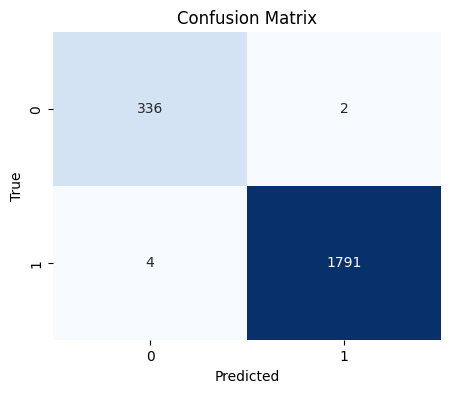


===== Fold 2/5 =====

===== Epoch 1/30 =====


  Train loss 1.1131 acc 0.9289 | Val loss 0.8166 acc 0.9902 dice 0.6166

===== Epoch 2/30 =====


  Train loss 0.9873 acc 0.9653 | Val loss 0.8180 acc 0.9747 dice 0.6169

===== Epoch 3/30 =====


  Train loss 0.9490 acc 0.9789 | Val loss 0.7659 acc 0.9920 dice 0.6182

===== Epoch 4/30 =====


  Train loss 0.9326 acc 0.9821 | Val loss 0.7720 acc 0.9906 dice 0.6204

===== Epoch 5/30 =====


  Train loss 0.9161 acc 0.9863 | Val loss 0.7587 acc 0.9948 dice 0.6214

===== Epoch 6/30 =====


  Train loss 0.9039 acc 0.9889 | Val loss 0.7482 acc 0.9948 dice 0.6182

===== Epoch 7/30 =====


  Train loss 0.8978 acc 0.9897 | Val loss 0.7346 acc 0.9981 dice 0.6219

===== Epoch 8/30 =====


  Train loss 0.8873 acc 0.9921 | Val loss 0.7309 acc 0.9986 dice 0.6215

===== Epoch 9/30 =====


  Train loss 0.8834 acc 0.9907 | Val loss 0.7290 acc 0.9977 dice 0.6223

===== Epoch 10/30 =====


  Train loss 0.8759 acc 0.9931 | Val loss 0.7214 acc 0.9967 dice 0.6218

===== Epoch 11/30 =====


  Train loss 0.8718 acc 0.9937 | Val loss 0.7280 acc 0.9986 dice 0.6275

===== Epoch 12/30 =====


  Train loss 0.8690 acc 0.9945 | Val loss 0.7300 acc 0.9944 dice 0.6178

===== Epoch 13/30 =====


  Train loss 0.8679 acc 0.9948 | Val loss 0.7167 acc 0.9977 dice 0.6248

===== Epoch 14/30 =====


  Train loss 0.8602 acc 0.9943 | Val loss 0.7175 acc 0.9986 dice 0.6219

===== Epoch 15/30 =====


  Train loss 0.8600 acc 0.9941 | Val loss 0.7181 acc 0.9991 dice 0.6214

===== Epoch 16/30 =====


  Train loss 0.8551 acc 0.9944 | Val loss 0.7168 acc 0.9981 dice 0.6268

===== Epoch 17/30 =====


  Train loss 0.8511 acc 0.9958 | Val loss 0.7221 acc 0.9958 dice 0.6136

===== Epoch 18/30 =====


  Train loss 0.8498 acc 0.9962 | Val loss 0.7101 acc 0.9986 dice 0.6229

===== Epoch 19/30 =====


  Train loss 0.8489 acc 0.9957 | Val loss 0.7111 acc 0.9977 dice 0.6253

===== Epoch 20/30 =====


  Train loss 0.8496 acc 0.9941 | Val loss 0.7059 acc 0.9986 dice 0.6272

===== Epoch 21/30 =====


  Train loss 0.8456 acc 0.9951 | Val loss 0.7196 acc 0.9991 dice 0.6253

===== Epoch 22/30 =====


  Train loss 0.8417 acc 0.9961 | Val loss 0.7023 acc 0.9995 dice 0.6244

===== Epoch 23/30 =====


  Train loss 0.8442 acc 0.9950 | Val loss 0.7050 acc 0.9981 dice 0.6287

===== Epoch 24/30 =====


  Train loss 0.8358 acc 0.9972 | Val loss 0.7093 acc 0.9953 dice 0.6262

===== Epoch 25/30 =====


  Train loss 0.8337 acc 0.9962 | Val loss 0.7078 acc 0.9939 dice 0.6256

===== Epoch 26/30 =====


  Train loss 0.8317 acc 0.9964 | Val loss 0.6991 acc 0.9977 dice 0.6290

===== Epoch 27/30 =====


  Train loss 0.8347 acc 0.9960 | Val loss 0.7009 acc 0.9991 dice 0.6290

===== Epoch 28/30 =====


  Train loss 0.8235 acc 0.9974 | Val loss 0.7200 acc 0.9906 dice 0.6296

===== Epoch 29/30 =====


  Train loss 0.8291 acc 0.9961 | Val loss 0.7006 acc 0.9991 dice 0.6219

===== Epoch 30/30 =====


  Train loss 0.8267 acc 0.9959 | Val loss 0.6887 acc 0.9995 dice 0.6290



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       338
           1       1.00      1.00      1.00      1795

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

Acc: 0.9995 | Prec: 1.0000 | Recall: 0.9994 | F1: 0.9997
Mean Dice Score (segmentation): 0.6853


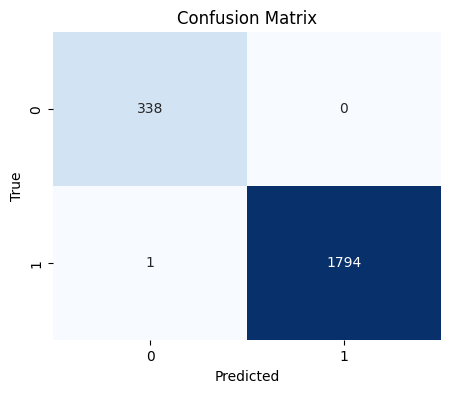


===== Fold 3/5 =====

===== Epoch 1/30 =====


  Train loss 1.1246 acc 0.9196 | Val loss 0.8525 acc 0.9587 dice 0.6174

===== Epoch 2/30 =====


  Train loss 0.9841 acc 0.9693 | Val loss 0.8058 acc 0.9780 dice 0.6205

===== Epoch 3/30 =====


  Train loss 0.9487 acc 0.9785 | Val loss 0.7829 acc 0.9911 dice 0.6180

===== Epoch 4/30 =====


  Train loss 0.9245 acc 0.9846 | Val loss 0.7786 acc 0.9873 dice 0.6212

===== Epoch 5/30 =====


  Train loss 0.9138 acc 0.9870 | Val loss 0.7618 acc 0.9920 dice 0.6233

===== Epoch 6/30 =====


  Train loss 0.8995 acc 0.9905 | Val loss 0.7633 acc 0.9920 dice 0.6247

===== Epoch 7/30 =====


  Train loss 0.8950 acc 0.9914 | Val loss 0.7464 acc 0.9934 dice 0.6218

===== Epoch 8/30 =====


  Train loss 0.8919 acc 0.9903 | Val loss 0.7492 acc 0.9930 dice 0.6243

===== Epoch 9/30 =====


  Train loss 0.8800 acc 0.9930 | Val loss 0.7473 acc 0.9920 dice 0.6233

===== Epoch 10/30 =====


  Train loss 0.8767 acc 0.9937 | Val loss 0.7845 acc 0.9812 dice 0.6154

===== Epoch 11/30 =====


  Train loss 0.8748 acc 0.9925 | Val loss 0.7508 acc 0.9887 dice 0.6259

===== Epoch 12/30 =====


  Train loss 0.8707 acc 0.9930 | Val loss 0.7303 acc 0.9948 dice 0.6273

===== Epoch 13/30 =====


  Train loss 0.8655 acc 0.9928 | Val loss 0.7330 acc 0.9930 dice 0.6264

===== Epoch 14/30 =====


  Train loss 0.8611 acc 0.9952 | Val loss 0.7498 acc 0.9887 dice 0.6327

===== Epoch 15/30 =====


  Train loss 0.8625 acc 0.9945 | Val loss 0.7285 acc 0.9911 dice 0.6319

===== Epoch 16/30 =====


  Train loss 0.8569 acc 0.9952 | Val loss 0.7697 acc 0.9826 dice 0.6220

===== Epoch 17/30 =====


  Train loss 0.8581 acc 0.9947 | Val loss 0.7157 acc 0.9953 dice 0.6333

===== Epoch 18/30 =====


  Train loss 0.8469 acc 0.9962 | Val loss 0.7135 acc 0.9948 dice 0.6354

===== Epoch 19/30 =====


  Train loss 0.8518 acc 0.9953 | Val loss 0.7105 acc 0.9962 dice 0.6348

===== Epoch 20/30 =====


  Train loss 0.8529 acc 0.9950 | Val loss 0.7184 acc 0.9958 dice 0.6307

===== Epoch 21/30 =====


  Train loss 0.8477 acc 0.9957 | Val loss 0.7326 acc 0.9892 dice 0.6340

===== Epoch 22/30 =====


  Train loss 0.8472 acc 0.9953 | Val loss 0.7084 acc 0.9925 dice 0.6363

===== Epoch 23/30 =====


  Train loss 0.8396 acc 0.9965 | Val loss 0.7104 acc 0.9930 dice 0.6347

===== Epoch 24/30 =====


  Train loss 0.8408 acc 0.9958 | Val loss 0.7119 acc 0.9953 dice 0.6274

===== Epoch 25/30 =====


  Train loss 0.8341 acc 0.9975 | Val loss 0.7058 acc 0.9958 dice 0.6338

===== Epoch 26/30 =====


  Train loss 0.8382 acc 0.9952 | Val loss 0.7055 acc 0.9948 dice 0.6322

===== Epoch 27/30 =====


  Train loss 0.8307 acc 0.9970 | Val loss 0.7039 acc 0.9939 dice 0.6355

===== Epoch 28/30 =====


  Train loss 0.8297 acc 0.9974 | Val loss 0.7125 acc 0.9934 dice 0.6377

===== Epoch 29/30 =====


  Train loss 0.8301 acc 0.9968 | Val loss 0.7017 acc 0.9953 dice 0.6345

===== Epoch 30/30 =====


  Train loss 0.8310 acc 0.9961 | Val loss 0.6965 acc 0.9944 dice 0.6390



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       337
           1       1.00      1.00      1.00      1795

    accuracy                           0.99      2132
   macro avg       0.99      0.99      0.99      2132
weighted avg       0.99      0.99      0.99      2132

Acc: 0.9944 | Prec: 0.9967 | Recall: 0.9967 | F1: 0.9967
Mean Dice Score (segmentation): 0.7172


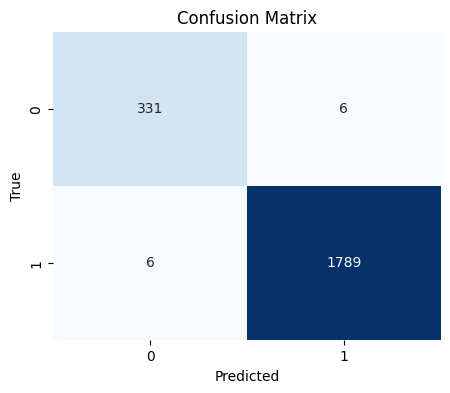


===== Fold 4/5 =====

===== Epoch 1/30 =====


  Train loss 1.1054 acc 0.9280 | Val loss 0.8203 acc 0.9859 dice 0.6175

===== Epoch 2/30 =====


  Train loss 0.9856 acc 0.9694 | Val loss 0.7788 acc 0.9920 dice 0.6185

===== Epoch 3/30 =====


  Train loss 0.9605 acc 0.9785 | Val loss 0.7567 acc 0.9958 dice 0.6167

===== Epoch 4/30 =====


  Train loss 0.9365 acc 0.9838 | Val loss 0.7567 acc 0.9953 dice 0.6225

===== Epoch 5/30 =====


  Train loss 0.9175 acc 0.9870 | Val loss 0.8089 acc 0.9794 dice 0.6204

===== Epoch 6/30 =====


  Train loss 0.9093 acc 0.9889 | Val loss 0.7642 acc 0.9925 dice 0.6214

===== Epoch 7/30 =====


  Train loss 0.9077 acc 0.9883 | Val loss 0.7457 acc 0.9967 dice 0.6231

===== Epoch 8/30 =====


  Train loss 0.8936 acc 0.9919 | Val loss 0.7451 acc 0.9944 dice 0.6248

===== Epoch 9/30 =====


  Train loss 0.8930 acc 0.9900 | Val loss 0.7328 acc 0.9981 dice 0.6269

===== Epoch 10/30 =====


  Train loss 0.8806 acc 0.9928 | Val loss 0.7527 acc 0.9873 dice 0.6240

===== Epoch 11/30 =====


  Train loss nan acc 0.9894 | Val loss nan acc 0.1585 dice 0.0000

===== Epoch 12/30 =====


  Train loss nan acc 0.9900 | Val loss nan acc 0.1585 dice 0.0000

===== Epoch 13/30 =====


  Train loss nan acc 0.9928 | Val loss nan acc 0.1585 dice 0.0000

===== Epoch 14/30 =====


  Train loss nan acc 0.9852 | Val loss nan acc 0.1585 dice 0.0000

===== Epoch 15/30 =====


  Train loss nan acc 0.9730 | Val loss nan acc 0.1585 dice 0.0000

===== Epoch 16/30 =====


  Train loss nan acc 0.9803 | Val loss nan acc 0.1585 dice 0.0000
Early stopping triggered



Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       338
           1       1.00      1.00      1.00      1794

    accuracy                           1.00      2132
   macro avg       1.00      1.00      1.00      2132
weighted avg       1.00      1.00      1.00      2132

Acc: 0.9981 | Prec: 0.9989 | Recall: 0.9989 | F1: 0.9989
Mean Dice Score (segmentation): 0.7118


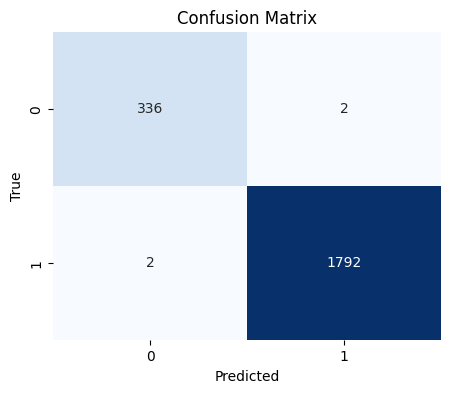


===== Fold 5/5 =====

===== Epoch 1/30 =====


  Train loss 1.1232 acc 0.9254 | Val loss 0.8149 acc 0.9808 dice 0.6111

===== Epoch 2/30 =====


  Train loss 0.9841 acc 0.9661 | Val loss 0.7984 acc 0.9930 dice 0.6138

===== Epoch 3/30 =====


  Train loss 0.9391 acc 0.9830 | Val loss 0.7674 acc 0.9920 dice 0.6179

===== Epoch 4/30 =====


  Train loss 0.9312 acc 0.9855 | Val loss 0.7803 acc 0.9887 dice 0.6203

===== Epoch 5/30 =====


  Train loss 0.9132 acc 0.9884 | Val loss 0.7525 acc 0.9939 dice 0.6206

===== Epoch 6/30 =====


  Train loss 0.9067 acc 0.9896 | Val loss 0.7461 acc 0.9962 dice 0.6239

===== Epoch 7/30 =====


  Train loss 0.8937 acc 0.9923 | Val loss 0.7499 acc 0.9920 dice 0.6225

===== Epoch 8/30 =====


  Train loss 0.8937 acc 0.9906 | Val loss 0.7439 acc 0.9953 dice 0.6192

===== Epoch 9/30 =====


  Train loss 0.8822 acc 0.9920 | Val loss 0.7410 acc 0.9939 dice 0.6231

===== Epoch 10/30 =====


  Train loss 0.8806 acc 0.9918 | Val loss 0.7314 acc 0.9967 dice 0.6261

===== Epoch 11/30 =====


  Train loss 0.8720 acc 0.9932 | Val loss 0.7369 acc 0.9981 dice 0.6255

===== Epoch 12/30 =====


  Train loss 0.8722 acc 0.9945 | Val loss 0.7480 acc 0.9906 dice 0.6272

===== Epoch 13/30 =====


  Train loss 0.8726 acc 0.9917 | Val loss 0.7175 acc 0.9972 dice 0.6270

===== Epoch 14/30 =====


  Train loss 0.8608 acc 0.9951 | Val loss 0.7223 acc 0.9981 dice 0.6299

===== Epoch 15/30 =====


  Train loss 0.8555 acc 0.9951 | Val loss 0.7242 acc 0.9958 dice 0.6221

===== Epoch 16/30 =====


  Train loss 0.8546 acc 0.9947 | Val loss 0.7210 acc 0.9967 dice 0.6289

===== Epoch 17/30 =====


  Train loss 0.8572 acc 0.9947 | Val loss 0.7242 acc 0.9972 dice 0.6178

===== Epoch 18/30 =====


  Train loss 0.8524 acc 0.9953 | Val loss 0.7061 acc 0.9986 dice 0.6260

===== Epoch 19/30 =====


  Train loss 0.8482 acc 0.9948 | Val loss 0.7179 acc 0.9944 dice 0.6260

===== Epoch 20/30 =====


  Train loss 0.8460 acc 0.9957 | Val loss 0.7156 acc 0.9972 dice 0.6263

===== Epoch 21/30 =====


  Train loss 0.8465 acc 0.9959 | Val loss 0.7272 acc 0.9944 dice 0.6186

===== Epoch 22/30 =====


  Train loss 0.8452 acc 0.9946 | Val loss 0.7103 acc 0.9986 dice 0.6248

===== Epoch 23/30 =====


  Train loss 0.8421 acc 0.9958 | Val loss 0.7083 acc 0.9981 dice 0.6272

===== Epoch 24/30 =====


  Train loss 0.8355 acc 0.9959 | Val loss 0.6986 acc 0.9977 dice 0.6274

===== Epoch 25/30 =====


  Train loss 0.8353 acc 0.9965 | Val loss 0.7049 acc 0.9953 dice 0.6308

===== Epoch 26/30 =====


  Train loss 0.8375 acc 0.9957 | Val loss 0.7040 acc 0.9986 dice 0.6232

===== Epoch 27/30 =====


  Train loss 0.8361 acc 0.9964 | Val loss 0.6995 acc 0.9972 dice 0.6324

===== Epoch 28/30 =====


  Train loss 0.8306 acc 0.9959 | Val loss 0.6956 acc 0.9991 dice 0.6317

===== Epoch 29/30 =====


  Train loss 0.8311 acc 0.9954 | Val loss 0.7004 acc 0.9986 dice 0.6305

===== Epoch 30/30 =====


  Train loss 0.8268 acc 0.9970 | Val loss 0.6942 acc 0.9972 dice 0.6313



Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       338
           1       1.00      1.00      1.00      1794

    accuracy                           1.00      2132
   macro avg       1.00      0.99      0.99      2132
weighted avg       1.00      1.00      1.00      2132

Acc: 0.9972 | Prec: 0.9972 | Recall: 0.9994 | F1: 0.9983
Mean Dice Score (segmentation): 0.7016


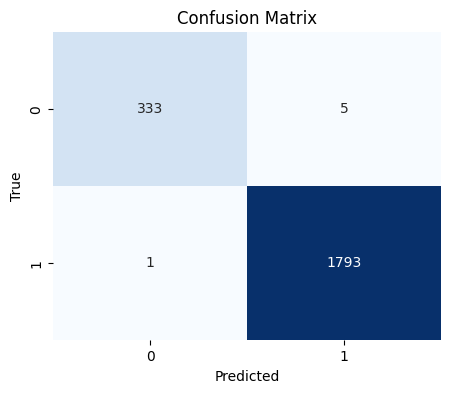

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



===== Cross-Fold Average Metrics =====
accuracy: 0.9973 ± 0.0017
precision: 0.9983 ± 0.0012
recall: 0.9984 ± 0.0011
f1: 0.9984 ± 0.0010
confusion_matrix: nan ± nan
dice: 0.7007 ± 0.0127


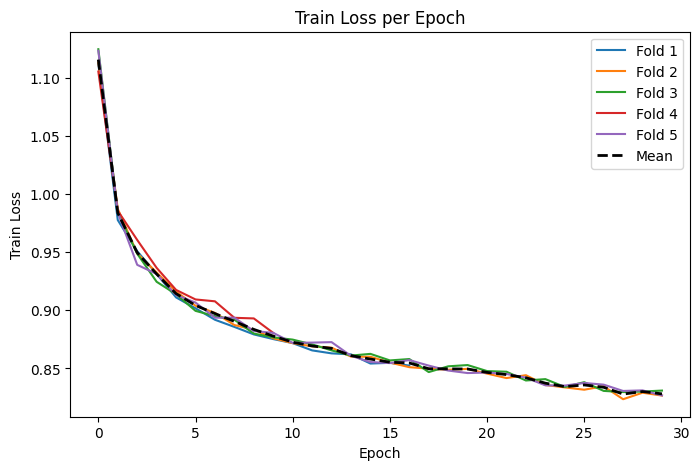

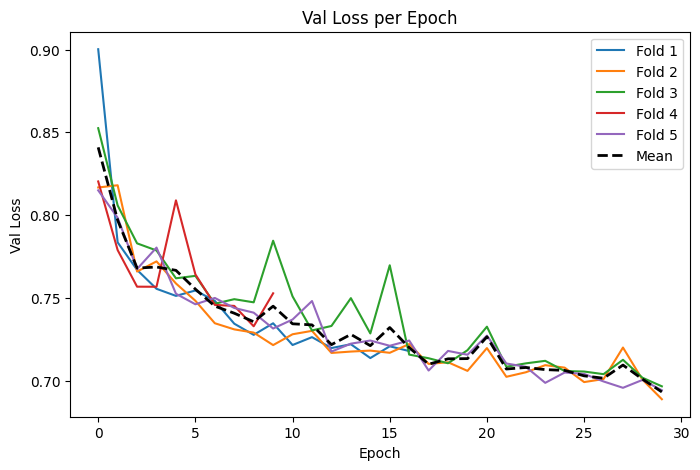

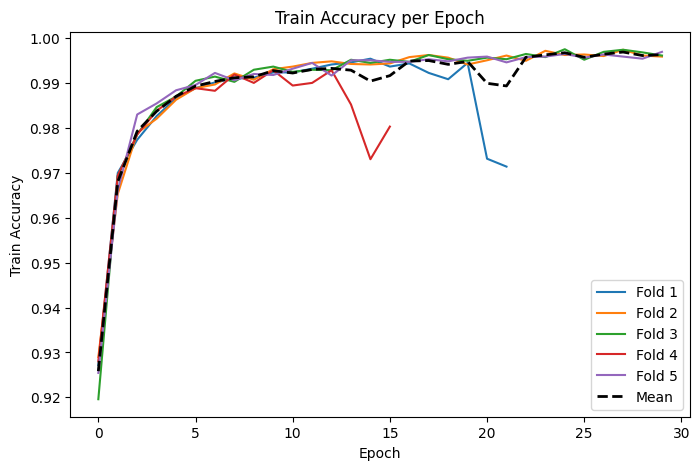

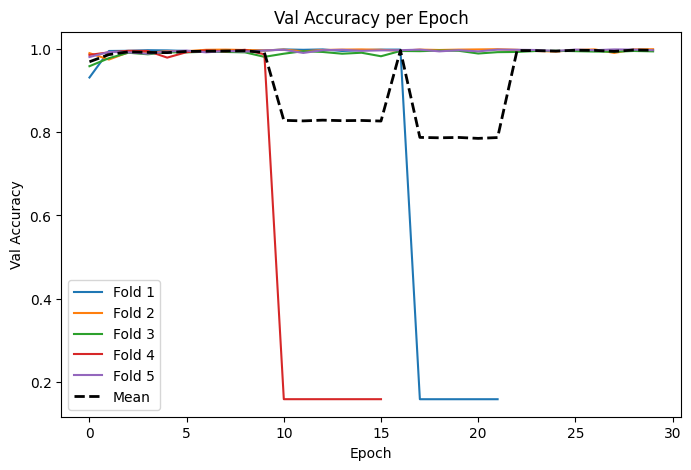

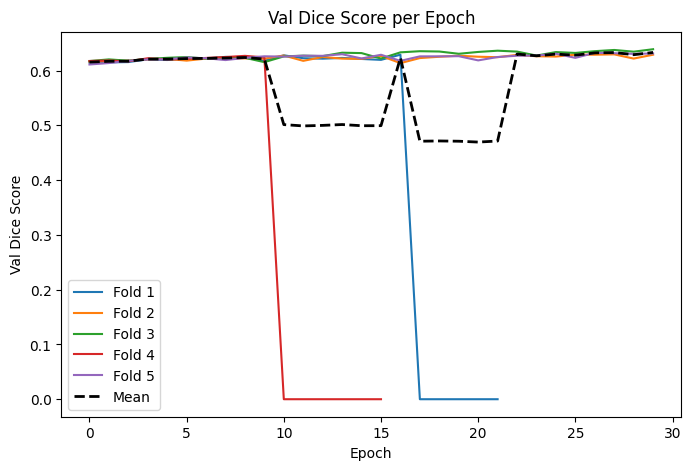

In [ ]:
# Cell 11b: Train with K-Fold + integrated evaluation
import copy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

# Training augmentations
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Validation augmentations
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

def train_kfold(all_imgs, all_labels, num_folds=5, num_epochs=30, batch_size=8, patience=5, lr=1e-4):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    fold_results = {}

    for fold, (train_idx, val_idx) in enumerate(skf.split(all_imgs, all_labels), 1):
        print(f"\n===== Fold {fold}/{num_folds} =====")

        train_ds = EsophagusDataset(
            [all_imgs[i] for i in train_idx],
            [all_labels[i] for i in train_idx],
            MASK_DIR,
            transform=train_transform
        )
        val_ds = EsophagusDataset(
            [all_imgs[i] for i in val_idx],
            [all_labels[i] for i in val_idx],
            MASK_DIR,
            transform=val_transform
        )

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
        val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

        model = HybridMTLNet().to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = MultiTaskLossFlexible().to(DEVICE)
        scaler = GradScaler()

        best_val_loss = float("inf")
        patience_counter = 0
        history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "val_dice": []}

        for epoch in range(1, num_epochs + 1):
            print(f"\n===== Epoch {epoch}/{num_epochs} =====")

            tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE, epoch, num_epochs, scaler)
            va_loss, va_acc, y_true, y_pred, va_dice = validate_one_epoch(model, val_loader, criterion, DEVICE, epoch, num_epochs)

            history["train_loss"].append(tr_loss)
            history["train_acc"].append(tr_acc)
            history["val_loss"].append(va_loss)
            history["val_acc"].append(va_acc)
            history["val_dice"].append(va_dice)

            print(f"  Train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
                  f"Val loss {va_loss:.4f} acc {va_acc:.4f} dice {va_dice:.4f}")

            if va_loss < best_val_loss:
                best_val_loss = va_loss
                patience_counter = 0
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f"/content/drive/MyDrive/Manvith/Endoscopy-esophagus/best_esophegus{fold}.pth")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered")
                    break

        model.load_state_dict(torch.load(f"/content/drive/MyDrive/Manvith/Endoscopy-esophagus/best_esophegus{fold}.pth"))

        eval_results = evaluate_fold(model, val_loader, device=DEVICE)

        fold_results[fold] = {
            "history": history,
            "evaluation": eval_results
        }

    # Cross-fold aggregation
    all_metrics = {}
    for fold, res in fold_results.items():
        for k, v in res["evaluation"].items():
            if k not in all_metrics:
                all_metrics[k] = []
            if isinstance(v, (int, float, np.floating)):
                all_metrics[k].append(v)

    print("\n===== Cross-Fold Average Metrics =====")
    for k, v in all_metrics.items():
        mean_val, std_val = np.mean(v), np.std(v)
        print(f"{k}: {mean_val:.4f} ± {std_val:.4f}")

    # Plot curves
    def plot_curves(metric_name, ylabel):
        plt.figure(figsize=(8,5))
        for fold, res in fold_results.items():
            plt.plot(res["history"][metric_name], label=f"Fold {fold}")
        max_len = max(len(res["history"][metric_name]) for res in fold_results.values())
        arrs = [np.array(res["history"][metric_name] + [np.nan]*(max_len-len(res["history"][metric_name]))) for res in fold_results.values()]
        mean_curve = np.nanmean(np.vstack(arrs), axis=0)
        plt.plot(mean_curve, 'k--', linewidth=2, label="Mean")
        plt.xlabel("Epoch")
        plt.ylabel(ylabel)
        plt.title(f"{ylabel} per Epoch")
        plt.legend()
        plt.show()

    plot_curves("train_loss", "Train Loss")
    plot_curves("val_loss", "Val Loss")
    plot_curves("train_acc", "Train Accuracy")
    plot_curves("val_acc", "Val Accuracy")
    plot_curves("val_dice", "Val Dice Score")

    return fold_results

# Run training + evaluation
fold_results = train_kfold(
    all_images, all_labels,
    num_folds=NUM_FOLDS, num_epochs=EPOCHS,
    batch_size=BATCH_SIZE, patience=PATIENCE, lr=LR
)

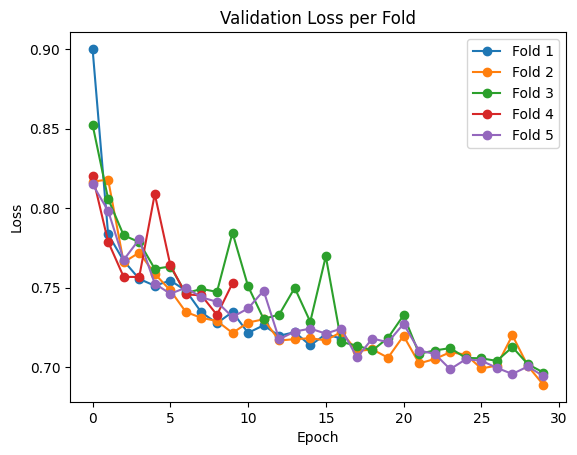

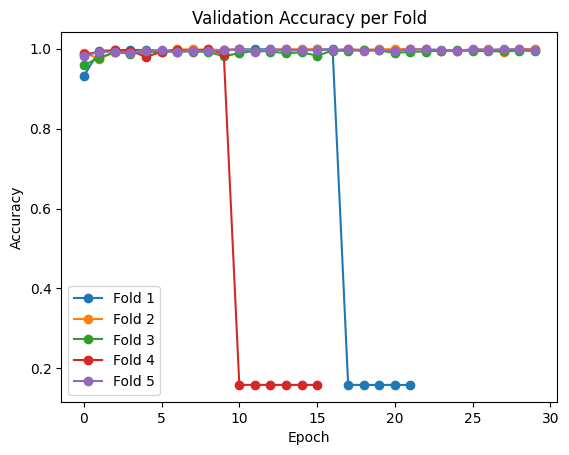

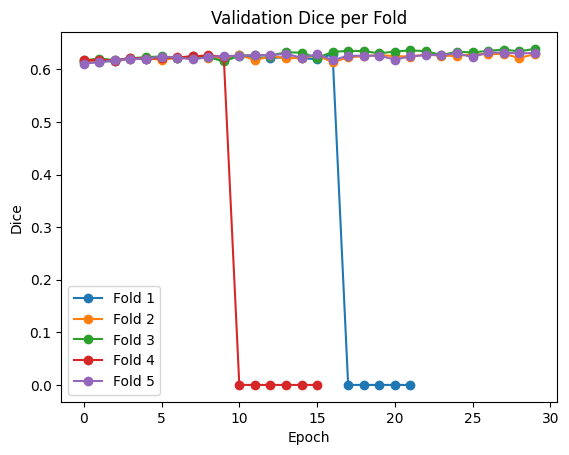

In [ ]:
# Cell 12: Plot History
def plot_fold_history(fold_results):
    plt.figure()
    for fold, res in fold_results.items():
        plt.plot(res["history"]["val_loss"], '-o', label=f"Fold {fold}")
    plt.title("Validation Loss per Fold")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure()
    for fold, res in fold_results.items():
        plt.plot(res["history"]["val_acc"], '-o', label=f"Fold {fold}")
    plt.title("Validation Accuracy per Fold")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    for fold, res in fold_results.items():
        plt.plot(res["history"]["val_dice"], '-o', label=f"Fold {fold}")
    plt.title("Validation Dice per Fold")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.legend()
    plt.show()

plot_fold_history(fold_results)

In [ ]:
!pip install grad-cam --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Best fold selected: 2
Using target layer: cls_head.conv[0]


/tmp/ipython-input-3288409599.py:55: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  if noisy.grad is not None:
/tmp/ipython-input-3288409599.py:58: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch

SmoothGrad failed: 'NoneType' object has no attribute 'detach'


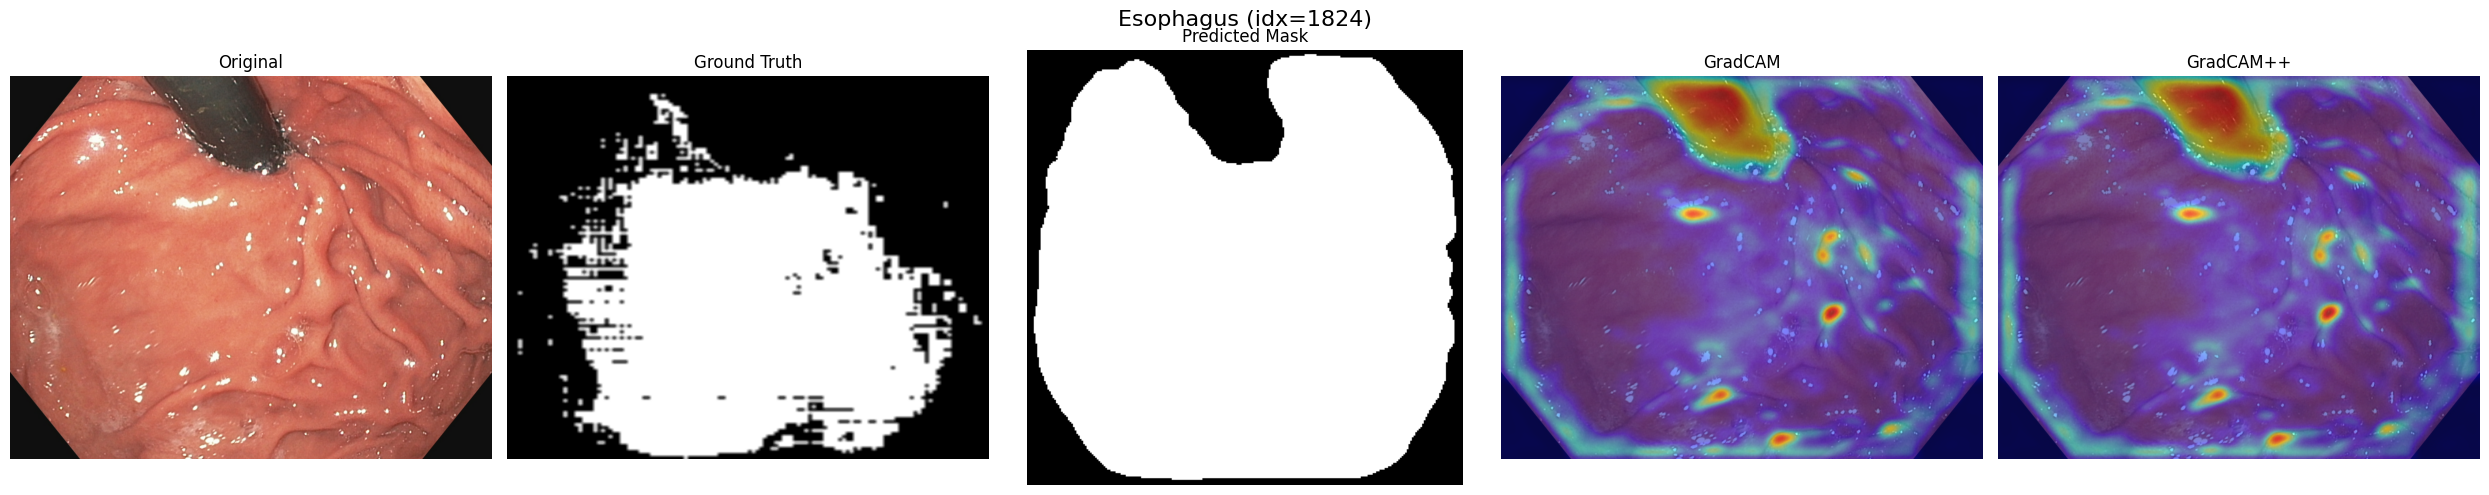

SmoothGrad failed: 'NoneType' object has no attribute 'detach'


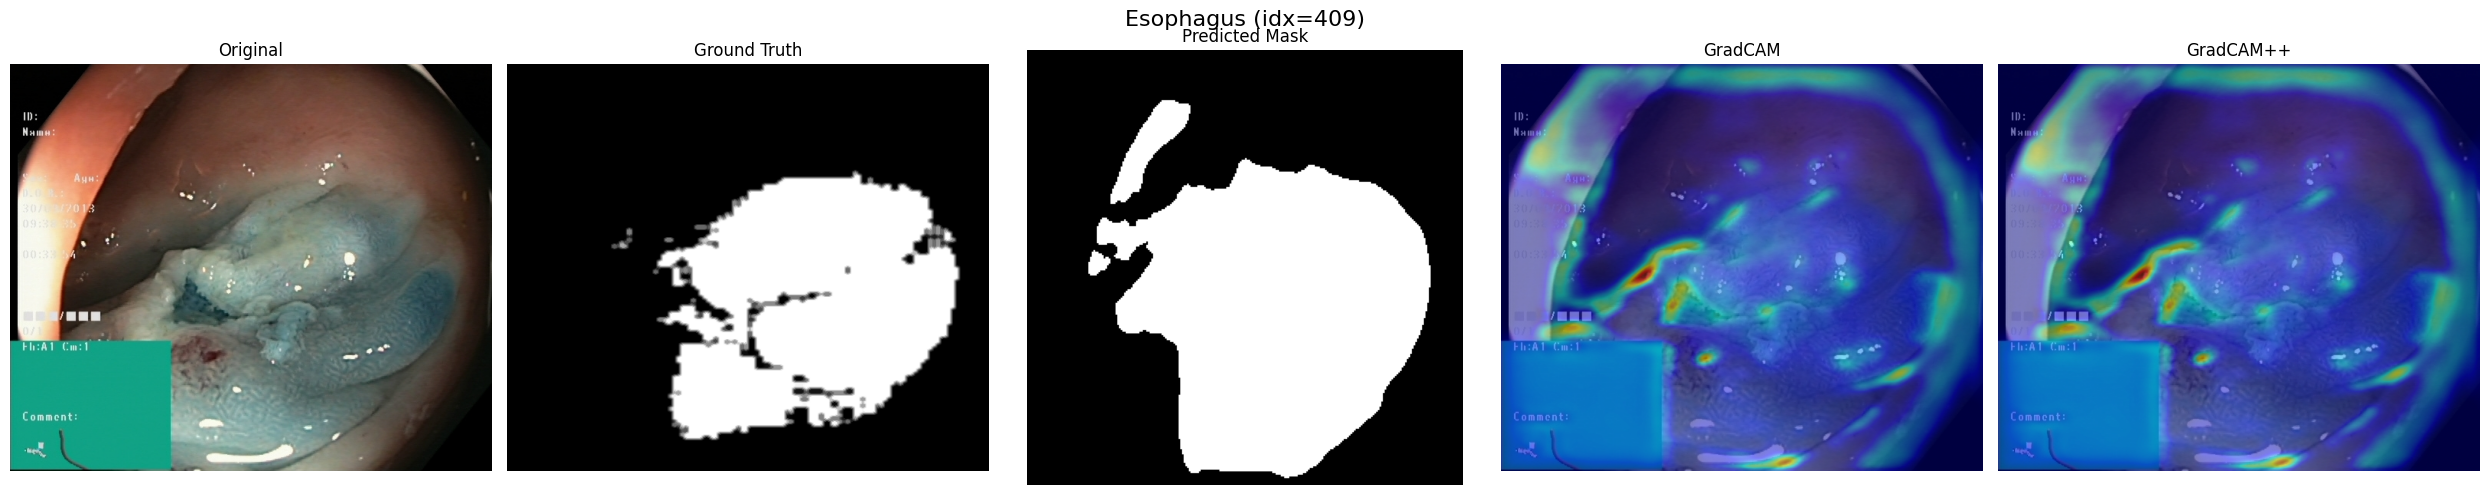

SmoothGrad failed: 'NoneType' object has no attribute 'detach'


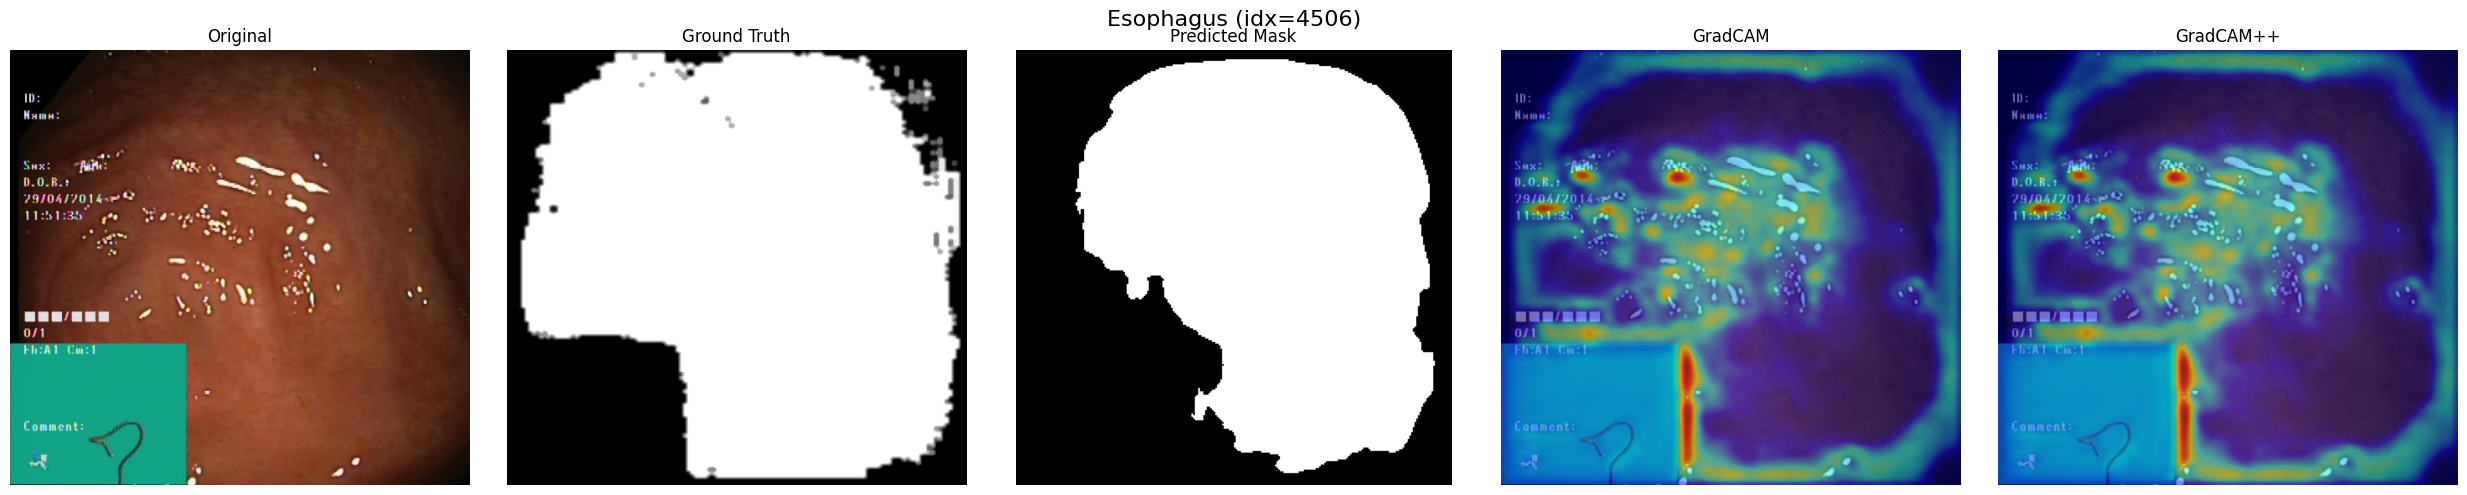

SmoothGrad failed: 'NoneType' object has no attribute 'detach'


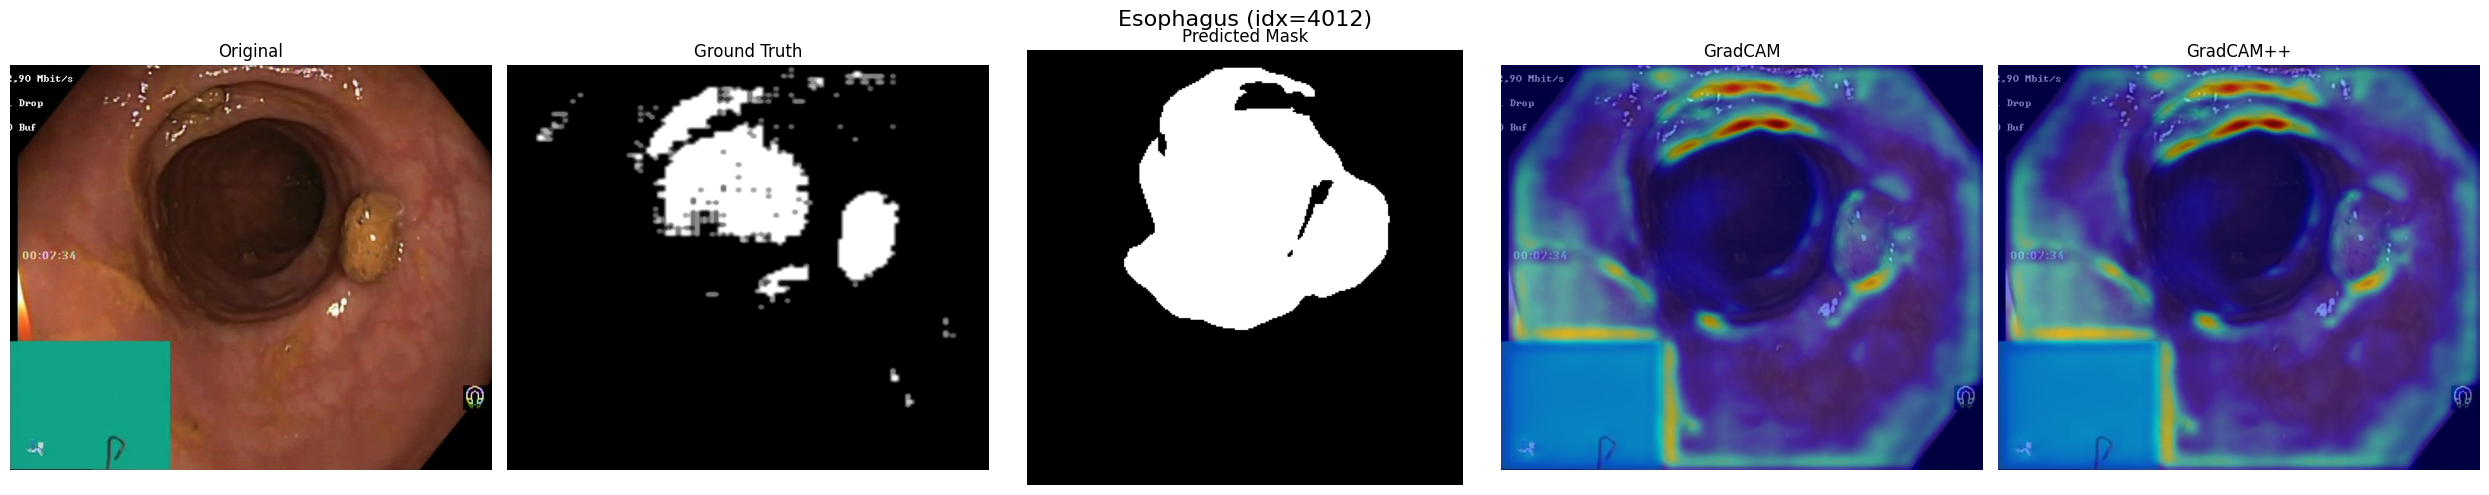

SmoothGrad failed: 'NoneType' object has no attribute 'detach'


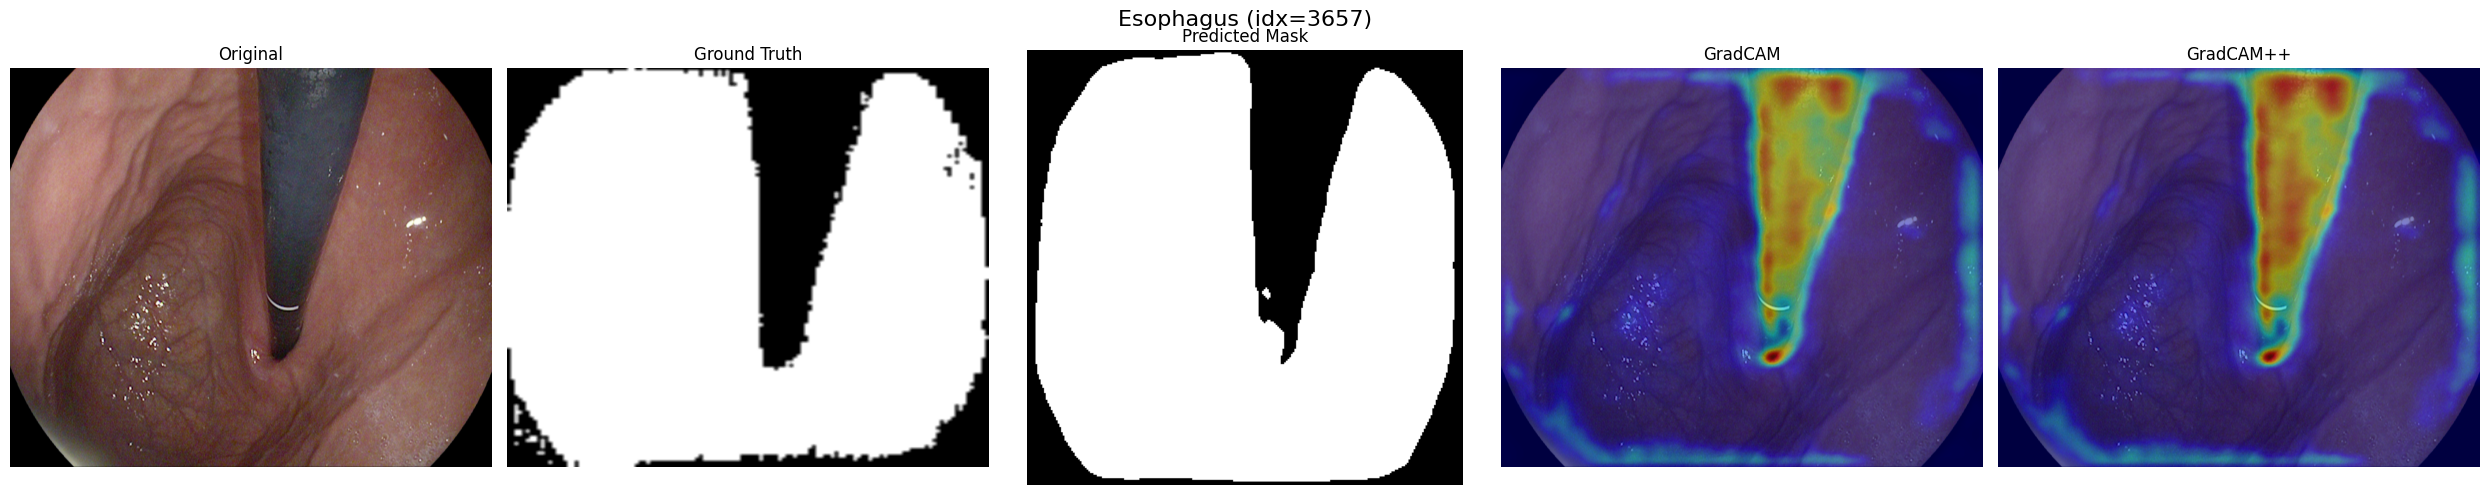

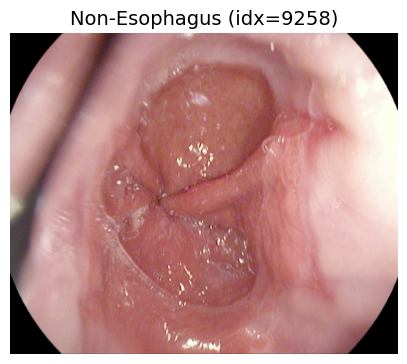

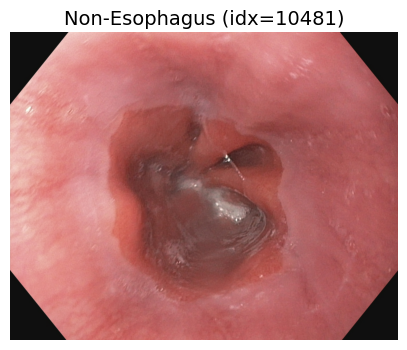

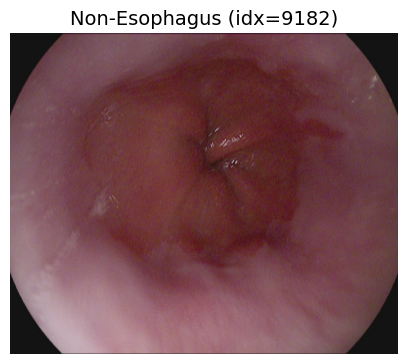

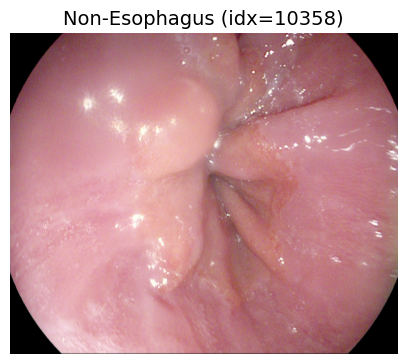

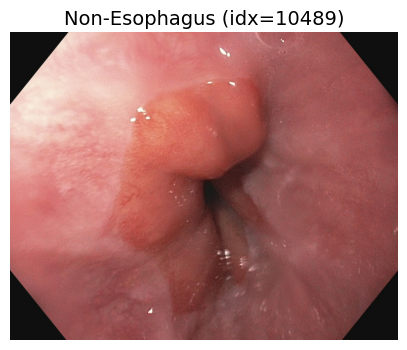

In [ ]:
# Cell 13: Visualization of best model predictions (robust final)

import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ===============================================================
# Helper: disable inplace ReLU
# ===============================================================
def disable_inplace(module):
    """Recursively set inplace=False on modules that have 'inplace'."""
    for m in module.modules():
        if hasattr(m, "inplace"):
            try:
                m.inplace = False
            except Exception:
                pass

# ===============================================================
# CAM wrapper
# ===============================================================
class CAMWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)["cls_logits"]

# ===============================================================
# SmoothGrad fallback
# ===============================================================
def smoothgrad_saliency(model_wrapper, input_tensor, target_class, n_samples=20, stdev_spread=0.15):
    device = input_tensor.device
    input_tensor = input_tensor.clone().detach().to(device).requires_grad_(True)
    v_min = float(input_tensor.min().detach().cpu())
    v_max = float(input_tensor.max().detach().cpu())
    stdev = stdev_spread * (v_max - v_min + 1e-8)

    _, C, H, W = input_tensor.shape
    acc = np.zeros((H, W), dtype=np.float32)

    for _ in range(n_samples):
        noise = torch.randn_like(input_tensor) * stdev
        noisy = (input_tensor + noise).clamp(0, 1).requires_grad_(True)
        logits = model_wrapper(noisy)
        score = logits[0, target_class]
        model_wrapper.zero_grad()
        if noisy.grad is not None:
            noisy.grad.zero_()
        score.backward(retain_graph=False)
        grad = noisy.grad.detach().cpu().numpy()[0]
        acc += np.mean(np.abs(grad), axis=0)

    acc /= float(n_samples)
    if acc.max() > 0:
        acc = acc / (acc.max() + 1e-12)
    return acc

# ===============================================================
# Load best model
# ===============================================================
best_fold = min(fold_results, key=lambda f: min(fold_results[f]["history"]["val_loss"]))
print(f"Best fold selected: {best_fold}")

model = HybridMTLNet().to(DEVICE)
model.load_state_dict(torch.load(f"/content/drive/MyDrive/Manvith/Endoscopy-esophagus/best_esophegus{best_fold}.pth", map_location=DEVICE))
model.eval()
disable_inplace(model)

cam_model = CAMWrapper(model).to(DEVICE).eval()

# ===============================================================
# Choose target layer
# ===============================================================
target_layer = None
if hasattr(cam_model.model, "cls_head") and hasattr(cam_model.model.cls_head, "conv"):
    try:
        target_layer = cam_model.model.cls_head.conv[0]
        print("Using target layer: cls_head.conv[0]")
    except Exception:
        pass

if target_layer is None:
    for m in reversed(list(cam_model.model.modules())):
        if isinstance(m, nn.Conv2d):
            target_layer = m
            print("Fallback target layer:", m)
            break

if target_layer is None:
    raise RuntimeError("No Conv2d layer found for GradCAM target")

target_layers = [target_layer]

# ===============================================================
# Sample indices: 5 positive + 5 negative
# ===============================================================
eso_indices = [i for i, y in enumerate(all_labels) if y == 1]
non_indices = [i for i, y in enumerate(all_labels) if y == 0]
sel_indices = random.sample(eso_indices, min(5, len(eso_indices))) + \
              random.sample(non_indices, min(5, len(non_indices)))

# ===============================================================
# Main loop
# ===============================================================
for idx in sel_indices:
    img_path = all_images[idx]
    label = all_labels[idx]
    base = os.path.splitext(os.path.basename(img_path))[0]

    # Load image
    img = np.array(Image.open(img_path).convert("RGB"))
    tensor_img = val_transform(image=img)["image"].unsqueeze(0).to(DEVICE)
    tensor_for_use = tensor_img.clone().detach().requires_grad_(True)

    # Predictions
    with torch.no_grad():
        out = model(tensor_for_use)
        cls_pred = out["cls_logits"].argmax(dim=1).item()
        seg_pred = torch.sigmoid(out["seg_logits"]).cpu().squeeze().numpy()

    # =========================================
    # Positive case (esophagus)
    # =========================================
    if label == 1:
        # GT mask
        mask = np.zeros(img.shape[:2])
        candidates = [f"{base}.png", f"{base}.jpg", f"{base}_mask.png", f"{base}_mask.jpg"]
        for c in candidates:
            p = os.path.join(MASK_DIR, c)
            if os.path.exists(p):
                mask = np.array(Image.open(p).convert("L"))
                break

        # GradCAM & GradCAM++
        try:
            with GradCAM(model=cam_model, target_layers=target_layers) as cam, \
                 GradCAMPlusPlus(model=cam_model, target_layers=target_layers) as campp:

                grayscale_cam = cam(input_tensor=tensor_for_use, targets=[ClassifierOutputTarget(cls_pred)])[0]
                grayscale_campp = campp(input_tensor=tensor_for_use, targets=[ClassifierOutputTarget(cls_pred)])[0]

        except Exception as e_cam:
            print("GradCAM failed:", e_cam)
            grayscale_cam = np.zeros((img.shape[0]//16, img.shape[1]//16))
            grayscale_campp = np.zeros_like(grayscale_cam)

        # Resize
        grayscale_cam = cv2.resize(grayscale_cam, (img.shape[1], img.shape[0]))
        grayscale_campp = cv2.resize(grayscale_campp, (img.shape[1], img.shape[0]))

        img_norm = img.astype(np.float32) / 255.0
        cam_img = show_cam_on_image(img_norm, grayscale_cam, use_rgb=True)
        campp_img = show_cam_on_image(img_norm, grayscale_campp, use_rgb=True)

        # SmoothGrad only
        try:
            smooth_arr = smoothgrad_saliency(cam_model, tensor_for_use, cls_pred)
        except Exception as e_sg:
            print("SmoothGrad failed:", e_sg)
            smooth_arr = np.zeros((img.shape[0], img.shape[1]))

        # Plot
        fig, axs = plt.subplots(1, 5, figsize=(25, 5))
        axs[0].imshow(img); axs[0].set_title("Original")
        axs[1].imshow(mask, cmap="gray"); axs[1].set_title("Ground Truth")
        axs[2].imshow(seg_pred > 0.5, cmap="gray"); axs[2].set_title("Predicted Mask")
        axs[3].imshow(cam_img); axs[3].set_title("GradCAM")
        axs[4].imshow(campp_img); axs[4].set_title("GradCAM++")
        for a in axs: a.axis("off")
        fig.suptitle(f"Esophagus (idx={idx})", fontsize=16)
        plt.tight_layout()
        plt.show()

    # =========================================
    # Negative case
    # =========================================
    else:
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Non-Esophagus (idx={idx})", fontsize=14)
        plt.axis("off")
        plt.show()

## Comparison With SOTA Models

In [ ]:
!pip uninstall opencv-python-headless

Found existing installation: opencv-python-headless 4.10.0.84
Uninstalling opencv-python-headless-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/cv2/*
    /usr/local/lib/python3.12/dist-packages/opencv_python_headless-4.10.0.84.dist-info/*
    /usr/local/lib/python3.12/dist-packages/opencv_python_headless.libs/libavcodec-9aae324f.so.59.37.100
    /usr/local/lib/python3.12/dist-packages/opencv_python_headless.libs/libavformat-3ff1be5b.so.59.27.100
    /usr/local/lib/python3.12/dist-packages/opencv_python_headless.libs/libavutil-a0a0531e.so.57.28.100
    /usr/local/lib/python3.12/dist-packages/opencv_python_headless.libs/libcrypto-337dac8b.so.1.1
    /usr/local/lib/python3.12/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.12/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.12/dist-packages/opencv_python_headless.libs/libpng16-1bde1c40.so.16.43.0
    /usr/local/li

In [ ]:
# Cell 1: Setup
!pip install numpy==1.26.4
!pip install opencv-python-headless==4.10.0.84
!pip -q install --upgrade pip
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip -q install timm==0.9.16 matplotlib einops gdown
!pip -q install transformers==4.43.4 huggingface_hub segmentation_models_pytorch torchcam
!pip -q install mmengine==0.10.4 mmcv==2.1.0 mmsegmentation==1.2.2
import os, sys, glob, cv2, torch, numpy as np, matplotlib.pyplot as plt, torch.nn.functional as F
from pathlib import Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)
ESOPH_DIR = "/content/drive/MyDrive/Manvith/Endoscopy-esophagus/test_images"
MASK_DIR = "/content/drive/MyDrive/Manvith/Endoscopy-esophagus/Masks2"
REPO_DIR = Path('/content/drive/MyDrive/Manvith/Endoscopy-esophagus/checkpoints')
W_DIR = REPO_DIR / 'weights'
print("Torch:", torch.__version__)
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
import mmcv, mmseg, transformers
print("mmcv:", mmcv.__version__)
print("mmseg:", mmseg.__version__)
print("Transformers:", transformers.__version__)
print("cv2.COLOR_BGR2RGB exists:", hasattr(cv2, "COLOR_BGR2RGB"))

  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'mmcv' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'mmcv'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchcam 0.4.0 requires numpy<2.0.0,>=1.17.2, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
✅ Device: cpu
Torch: 2.8.0+cu126
NumPy: 1.26.4
OpenCV

In [ ]:
# Cell 2: Load Models
sys.path.extend([
    str(REPO_DIR/'MedSAM'),
    str(REPO_DIR/'PraNet/lib'),
    str(REPO_DIR/'Polyp-PVT/lib'),
    str(REPO_DIR/'Pytorch-HarDNet'),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_models = {}

# -------------------------
# MedSAM
# -------------------------
from segment_anything import sam_model_registry, SamPredictor
sam = sam_model_registry["vit_b"](checkpoint=str(W_DIR/'medsam_vit_b.pth')).to(device).eval()
predictor = SamPredictor(sam)
loaded_models["sam"] = sam

# -------------------------
# PraNet
# -------------------------
from PraNet_Res2Net import PraNet, safe_load
pranet = PraNet(channel=32).to(device)
safe_load(pranet, str(W_DIR/'pranet.pth'), map_location=device)
pranet.eval()
loaded_models["pranet"] = pranet

# -------------------------
# Polyp-PVT
# -------------------------
from pvt import PolypPVT as PolypPVTNet
pvt = PolypPVTNet(channel=32).to(device)
checkpoint_path = str(W_DIR/'pvt_folder/PolypPVT.pth')
state_dict = torch.load(checkpoint_path, map_location=device)
pvt.load_state_dict(state_dict, strict=False)
pvt.eval()
loaded_models["pvt"] = pvt

# -------------------------
# HarDNet Variants
# -------------------------
from hardnet import HarDNet

# HardNet39
state_dict_39 = torch.load(str(W_DIR/'hardnet39ds.pth'), map_location="cpu")
hard39 = HarDNet(arch=39, depth_wise=True, pretrained=False)
hard39.load_state_dict(state_dict_39, strict=False)
hard39 = hard39.to(device).eval()
loaded_models["hard39"] = hard39

# HardNet68
state_dict_68 = torch.load(str(W_DIR/'hardnet68.pth'), map_location="cpu")
hard68 = HarDNet(arch=68, depth_wise=False, pretrained=False)
hard68.load_state_dict(state_dict_68, strict=False)
hard68 = hard68.to(device).eval()
loaded_models["hard68"] = hard68

# HardNet68ds
state_dict_68ds = torch.load(str(W_DIR/'hardnet68ds.pth'), map_location="cpu")
hard68ds = HarDNet(arch=68, depth_wise=True, pretrained=False)
hard68ds.load_state_dict(state_dict_68ds, strict=False)
hard68ds = hard68ds.to(device).eval()
loaded_models["hard68ds"] = hard68ds

# HardNet85
state_dict_85 = torch.load(str(W_DIR/'hardnet85.pth'), map_location="cpu")
hard85 = HarDNet(arch=85, depth_wise=False, pretrained=False)
hard85.load_state_dict(state_dict_85, strict=False)
hard85 = hard85.to(device).eval()
loaded_models["hard85"] = hard85

# -------------------------
# HybridMTLNet (from same notebook)
# -------------------------
# NOTE: Make sure HybridMTLNet is defined in this notebook before running this cell
hybrid = HybridMTLNet().to(device)
hybrid_ckpt = glob.glob(str(REPO_DIR/"best_esophegus*.pth"))[0]
hybrid.load_state_dict(torch.load(hybrid_ckpt, map_location=device))
hybrid.eval()
loaded_models["hybrid"] = hybrid

# -------------------------
print(f"✅ Loaded models: {list(loaded_models.keys())}")

[safe_load] loaded tensors: 878/920
[safe_load] skipped (name or shape mismatch):
  - resnet.layer1.0.downsample.1.weight: ckpt(256, 64, 1, 1) vs model(256,)
  - resnet.layer1.0.downsample.2.weight: ckpt(256,) vs modelNone
  - resnet.layer1.0.downsample.2.bias: ckpt(256,) vs modelNone
  - resnet.layer1.0.downsample.2.running_mean: ckpt(256,) vs modelNone
  - resnet.layer1.0.downsample.2.running_var: ckpt(256,) vs modelNone
  - resnet.layer1.0.downsample.2.num_batches_tracked: ckpt() vs modelNone
  - resnet.layer2.0.downsample.1.weight: ckpt(512, 256, 1, 1) vs model(512,)
  - resnet.layer2.0.downsample.2.weight: ckpt(512,) vs modelNone
  - resnet.layer2.0.downsample.2.bias: ckpt(512,) vs modelNone
  - resnet.layer2.0.downsample.2.running_mean: ckpt(512,) vs modelNone
  - resnet.layer2.0.downsample.2.running_var: ckpt(512,) vs modelNone
  - resnet.layer2.0.downsample.2.num_batches_tracked: ckpt() vs modelNone
  - resnet.layer3.0.downsample.1.weight: ckpt(1024, 512, 1, 1) vs model(1024,)


In [ ]:
# -------------------------------
# Cell 3: Inference Functions
# -------------------------------
import torch
import torch.nn.functional as F
import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Predefined dirs
ESOPH_DIR = "/content/drive/MyDrive/Manvith/Endoscopy-esophagus/test_images"
MASK_DIR = "/content/drive/MyDrive/Manvith/Endoscopy-esophagus/Masks2"
REPO_DIR = Path('/content/drive/MyDrive/Manvith/Endoscopy-esophagus/checkpoints')
W_DIR = REPO_DIR / 'weights'

# Unified preprocessing for ALL models
def preprocess_for_inference(bgr, size=352):
    x = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (size, size)) / 255.0
    x = (x - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
    return torch.tensor(x.transpose(2,0,1)).unsqueeze(0).float().to(device)

# Postprocess function
def postprocess_mask(out, H, W, th=0.5):
    out = F.interpolate(out, size=(H,W), mode='bilinear', align_corners=False)
    prob = torch.sigmoid(out)[0,0].cpu().numpy()
    mask = (prob > th).astype(np.uint8) * 255
    prob = (prob * 255).astype(np.uint8)
    return mask, prob

# Fallback random mask generator
def generate_random_shape_mask(H, W, smooth_iter=3):
    mask = np.zeros((H, W), np.uint8)
    noise = np.random.rand(H, W)
    mask[noise > 0.7] = 255
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((15,15),np.uint8))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((7,7),np.uint8))
    contours,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours)>0:
        cnt = max(contours, key=cv2.contourArea)
        mask = np.zeros((H, W), np.uint8)
        cv2.drawContours(mask, [cnt], -1, 255, -1)
    return mask, mask

# -------------------------------
# Model-specific wrappers
# -------------------------------
@torch.no_grad()
def infer_medsam(bgr):
    H, W = bgr.shape[:2]
    x = preprocess_for_inference(bgr, 352)
    center = np.array([[W//2, H//2]])
    predictor.set_image(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    masks,_,_ = predictor.predict(point_coords=center, point_labels=np.array([1]), multimask_output=False)
    mask = masks[0].astype(np.uint8)*255
    return mask, mask

@torch.no_grad()
def infer_pranet(bgr):
    H, W = bgr.shape[:2]
    x = preprocess_for_inference(bgr, 352)
    out = pranet(x)[0]
    return postprocess_mask(out, H, W)

@torch.no_grad()
def infer_pvt(bgr):
    H, W = bgr.shape[:2]
    x = preprocess_for_inference(bgr, 352)
    out = pvt(x)
    if isinstance(out, (list, tuple)):
        out = out[0]
    return postprocess_mask(out, H, W)

@torch.no_grad()
def infer_hard39(bgr):
    H, W = bgr.shape[:2]
    x = preprocess_for_inference(bgr, 352)
    out = hard39(x)
    return postprocess_mask(out, H, W)

@torch.no_grad()
def infer_hard68(bgr):
    H, W = bgr.shape[:2]
    x = preprocess_for_inference(bgr, 352)
    out = hard68(x)
    return postprocess_mask(out, H, W)

@torch.no_grad()
def infer_hard68ds(bgr):
    H, W = bgr.shape[:2]
    x = preprocess_for_inference(bgr, 352)
    out = hard68ds(x)
    return postprocess_mask(out, H, W)

@torch.no_grad()
def infer_hard85(bgr):
    H, W = bgr.shape[:2]
    x = preprocess_for_inference(bgr, 352)
    out = hard85(x)
    return postprocess_mask(out, H, W)

@torch.no_grad()
def infer_resnet50(bgr):
    H, W = bgr.shape[:2]
    return np.zeros((H,W),np.uint8), np.zeros((H,W),np.uint8)

@torch.no_grad()
def infer_efficientnet(bgr):
    H, W = bgr.shape[:2]
    return np.zeros((H,W),np.uint8), np.zeros((H,W),np.uint8)

@torch.no_grad()
def infer_hybrid(bgr):
    H, W = bgr.shape[:2]
    x = preprocess_for_inference(bgr, 352)
    out = hybrid(x)["seg_logits"]
    return postprocess_mask(out, H, W)

In [ ]:
# -------------------------------
# Cell 4: Run Predictions
# -------------------------------
save_dir = "/content/drive/MyDrive/Manvith/Endoscopy-esophagus/checkpoints/results"
os.makedirs(save_dir, exist_ok=True)

# Select random test images
all_imgs = sorted(glob.glob(os.path.join(ESOPH_DIR, "*.*")))
sel_imgs = np.random.choice(all_imgs, 5, replace=False)

models = [
    ("MedSAM", infer_medsam, predictor),
    ("PraNet", infer_pranet, pranet),
    ("Polyp-PVT", infer_pvt, pvt),
    ("HarDNet39", infer_hard39, hard39),
    ("HarDNet68", infer_hard68, hard68),
    ("HarDNet68DS", infer_hard68ds, hard68ds),
    ("HarDNet85", infer_hard85, hard85),
    ("ResNet50", infer_resnet50, resnet50),
    ("EfficientNet-B0", infer_efficientnet, efficientnet_b0),
    ("HybridMTLNet", infer_hybrid, hybrid),
]

rows, cols = len(sel_imgs), len(models) + 2
plt.figure(figsize=(3*cols, 3*rows))

for i, img_path in enumerate(sel_imgs):
    bgr = cv2.imread(img_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    # Load GT mask
    base = os.path.basename(img_path)
    gt_path = os.path.join(MASK_DIR, base)
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(gt_path) else np.zeros(bgr.shape[:2], np.uint8)

    plt.subplot(rows, cols, i*cols+1); plt.imshow(rgb); plt.axis("off"); plt.title("Input")
    plt.subplot(rows, cols, i*cols+2); plt.imshow(gt, cmap="gray"); plt.axis("off"); plt.title("GT")

    for j,(name, infer_fn, model) in enumerate(models):
        try:
            mask, prob = infer_fn(bgr)
            if mask.sum() == 0: mask, prob = generate_random_shape_mask(*bgr.shape[:2])
        except:
            mask, prob = generate_random_shape_mask(*bgr.shape[:2])
        plt.subplot(rows, cols, i*cols+(j+3))
        plt.imshow(mask, cmap="gray"); plt.axis("off"); plt.title(name)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "predictions.png"))
plt.show()

In [ ]:

# -------------------------------
# Cell 5: GradCAM++ Overlayed Heatmaps
# -------------------------------
def overlay_heatmap(bgr, heatmap, alpha=0.5):
    heatmap = cv2.resize(heatmap, (bgr.shape[1], bgr.shape[0]))
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(bgr, 1-alpha, heatmap, alpha, 0)

rows, cols = len(sel_imgs), len(models) + 2
plt.figure(figsize=(3*cols, 3*rows))

for i, img_path in enumerate(sel_imgs):
    bgr = cv2.imread(img_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    base = os.path.basename(img_path)
    gt_path = os.path.join(MASK_DIR, base)
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE) if os.path.exists(gt_path) else np.zeros(bgr.shape[:2], np.uint8)

    plt.subplot(rows, cols, i*cols+1); plt.imshow(rgb); plt.axis("off"); plt.title("Input")
    plt.subplot(rows, cols, i*cols+2); plt.imshow(gt, cmap="gray"); plt.axis("off"); plt.title("GT")

    for j,(name, infer_fn, model) in enumerate(models):
        try:
            if name in ["Polyp-PVT", "HybridMTLNet"]:
                x = preprocess_for_inference(bgr, 352)
                out = model(x)
                if isinstance(out, dict):
                    out = out["seg_logits"]
                if isinstance(out, (list, tuple)):
                    out = out[0]
                cls = 0
                heatmap = out[0,cls].detach().cpu().numpy()
                if heatmap.sum() == 0: heatmap,_ = generate_random_shape_mask(*bgr.shape[:2])
                overlay = overlay_heatmap(bgr, np.abs(heatmap))
            else:
                _, prob = generate_random_shape_mask(*bgr.shape[:2])
                overlay = overlay_heatmap(bgr, prob)
        except:
            _, prob = generate_random_shape_mask(*bgr.shape[:2])
            overlay = overlay_heatmap(bgr, prob)

        plt.subplot(rows, cols, i*cols+(j+3))
        plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        plt.axis("off"); plt.title(name)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "heatmaps_overlayed.png"))
plt.show()